# Methods for Data Science: Course Work 2

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

1.1.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# read in the data
train_MLP = pd.read_csv("./MNIST_train.csv")
test_MLP = pd.read_csv("./MNIST_test.csv")

y_train = train_MLP.loc[:, "label"]
X_train = train_MLP.iloc[:, 1:]

y_test = test_MLP.loc[:, "label"]
X_test = test_MLP.iloc[:, 1:]

In order to use the KL divergence loss we need to work with probability distributions and so I have one-hot encoded the train and test classes (see later). This creates an N x N matrix $Y$ where $Y_{ij} = 1$ if $y_i = j$ (using python indexing) and 0 otherwise, here $y$ is the vector of classes.

In [3]:
# normalise input data by dividing by max pixel value
X_train_MLP = X_train.to_numpy() / 255.0
X_test_MLP = X_test.to_numpy() / 255.0

y_train_MLP = y_train.to_numpy()
y_test_MLP = y_test.to_numpy()

# we need to one-hot encode the y values so that we have a matrix of probabilities

def one_hot_encode(arr):
    num_classes = len(np.unique(arr))  # count the number of unique values

    # create a binary matrix with one row for each observation and one column for each unique value
    one_hot_matrix = np.zeros((len(arr), num_classes))

    # set the value of the element corresponding to the category to 1, and set all other elements to 0
    for i, value in enumerate(np.unique(arr)):
        one_hot_matrix[arr == value, i] = 1

    return one_hot_matrix

Y_train_MLP = one_hot_encode(y_train_MLP)

In [4]:
def softplus(x):
    # K x h_out input
    # no need to specify axis because will apply element-wise
    return np.log(1 + np.exp(x))

def softmax(x):
    # K x h_out input
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def dense(x, W, b):
    
    # x: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    h = b + x.dot(W)
    return h

def mlp(x, W0, b0, W1, b1, W2, b2, W3, b3):
    a1 = dense(x, W0, b0)
    h1 = softplus(a1)
    a2 = dense(h1, W1, b1)
    h2 = softplus(a2)
    a3 = dense(h2, W2, b2)
    h3 = softplus(a3)
    a4 = dense(h3, W3, b3)
    y_pred = softmax(a4)

    return y_pred

The Kullback-Leibler divergence loss function is defined as:

$$
\begin{aligned}
\text{KL}(y \,\,|| f(x_i))\,\, &= \,\, \sum\limits_{i=1}^{n}\,\, y_i \log \frac{y_i}{f(x_i)}
\end{aligned}
$$


where $y_i$ and $f(x_i)$ are the true and the network predicted probability distributions, respectively, and $n$ is the number of classes.

Since we have used `softmax` as the activation function (for the output layer) of this neural network, the output is a matrix of probabilities. This also means that we have to use chain rule to calculate the output error. Specifically:

$$
\begin{aligned}
\frac{\delta L_{j}}{\delta a_{j}^{out}} &= \frac{\delta L_{j}}{\delta s_{j}} \cdot \frac{\delta s_{j}}{\delta a_{j}^{out}}
\end{aligned}
$$

where $L_j$ is the j-th row of the KL divergence loss matrix, $a_j^{out}$ is the $j$-th row of the pre-activations of the output layer, and $s_{j}$ is the j-th row of the post-activations of the output layer i.e. after we have applied `softmax` to the pre-activations.

Using the formula for KL divergence and noting that `y_pred` or $f(x_i)$ is $s_{j}$ we get that:
$$
\begin{aligned}
\frac{\delta L_{j}}{\delta s_{j}} &= -\frac{y_j}{s_j}
\end{aligned}
$$

To find $\frac{\delta s_{j}}{\delta a_{j}^{out}}$ we can use chain rule on $log(s_j)$. We have:
$$
\begin{aligned}
s_j &= \frac{e^{a_j}}{\sum_{l=1}^{n_{out}} e^{a_l}} \\
log(s_j) &= a_j - log(\sum_{l=1}^{n_{out}} e^{a_l}) \\
\frac{\delta log(s_{j})}{\delta a_{j}^{out}} &=  \delta_{ij} - s_j \\
\frac{\delta s_{j}}{\delta a_{j}^{out}} &= s_j \cdot (\delta_{ij} - s_j) \\ 
\end{aligned}
$$

Above we have introduced the Kronecker delta notation (which is 1 whenever $i=j$ and 0 otherwise). Combining all the equations together we end up with $\delta^{(4)} = s_j - y_j$, where $\delta^{(4)}$ is the output error for this neural network.

In [5]:
# define kl_divergence loss function

def kl_divergence(y_true, y_pred):
    # y_true and y_pred are matrices
    # add a constant to avoid underflow
    loss_mat = y_true @ (np.log(y_true + 1e-100) - np.log(y_pred + 1e-100)).T

    return np.mean(np.diag(loss_mat))

# now we define the functions required to perform error back propagation.

def output_error(y_batch, y_pred):
    # y_batch and y_pred are K x 10 arrays

    # derivative of kl_divergence with respect to pre-activation
    # need to use chain rule because our ouput has softmax applied to it!
    # we end up with the following equation
    
    return y_pred - y_batch

def activation_derivative(x):
    return np.exp(x) / (1 + np.exp(x))

def backpropagate(delta, W, a):
    
    # delta: K x N array of errors (N is either 10 or 200 depending on the layer)
    # W: 200 x N array
    # a: K x 200 array of pre-activations of the previous layer
    
    # K here is the minibatch size, hence we are applying the backpropagation formula 
    # for each sample in the mini-batch (this is why we use the element-wise product)
    
    # We want to compute the derivative of the activations with respect to the pre-activations 
    # of the previous layer. To do so, we matrix multiply the error by the weights and then by 
    # the derivative of the activations (element-wise multiplication).
    
    d_a = activation_derivative(a)[..., np.newaxis] * W @ delta[:, :, np.newaxis]
    
    return np.squeeze(d_a)

def grads(delta1, delta2, delta3, delta4, h0, h1, h2, h3):
    
    # delta1: K x 200 array of 1st hidden layer errors
    # delta2: K x 200 array of 2nd hidden layer errors
    # delta3: K x 200 array of 3rd hidden layer errors
    # delta4: K x 10 array of output errors
    # h0: K x input_dim array of inputs
    # h1: K x 200 array of 1st hidden layer post-activations
    # h2: K x 200 array of 2nd hidden layer post-activations
    # h3: K x 200 array of 3rd hidden layer post-activations
    # returns: tuple of arrays of shape (input_dim x 200), (200,), (200 x 200), (200,), (200 x 200), (200,), 
    # (200 x 10), (10,) for gradients
    
    grad_W0 = delta1[:, np.newaxis, :] * h0[:, :, np.newaxis]
    grad_b0 = delta1
    grad_W1 = delta2[:, np.newaxis, :] * h1[:, :, np.newaxis]
    grad_b1 = delta2
    grad_W2 = delta3[:, np.newaxis, :] * h2[:, :, np.newaxis]
    grad_b2 = delta3
    grad_W3 = delta4[:, np.newaxis, :] * h3[:, :, np.newaxis]
    grad_b3 = delta4
    
    grad_W0 = np.mean(grad_W0, axis=0)
    grad_b0 = np.mean(grad_b0, axis=0)
    grad_W1 = np.mean(grad_W1, axis=0)
    grad_b1 = np.mean(grad_b1, axis=0)
    grad_W2 = np.mean(grad_W2, axis=0)
    grad_b2 = np.mean(grad_b2, axis=0)
    grad_W3 = np.mean(grad_W3, axis=0)
    grad_b3 = np.mean(grad_b3, axis=0)
    
    return grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3


In [6]:
def sgd(x_train, y_train, lr, epochs=40, batch_size=128, print_out = True):
    if print_out:
        print(f"learning rate: {lr}")
    # initialise the weights and biases
    n_in = x_train.shape[1]
    n_hide = 200
    n_out = 10

    # goes into hidden 1
    var0 = 2 / (n_in + n_hide)
    W0 = np.random.randn(n_in, n_hide) * np.sqrt(var0)
    b0 = np.zeros(n_hide)

    # goes into hidden 2
    var1 = 2 / (n_hide + n_hide)
    W1 = np.random.randn(n_hide, n_hide) * np.sqrt(var1)
    b1 = np.zeros(n_hide)

    # goes into hidden 3
    var2 = var1
    W2 = np.random.randn(n_hide, n_hide) * np.sqrt(var2)
    b2 = np.zeros(n_hide)

    # goes into output
    var3 = 2 / (n_hide + n_out)
    W3 = np.random.randn(n_hide, n_out) * np.sqrt(var3)
    b3 = np.zeros(n_out)
    
    for epoch in range(epochs):
        # Shuffle the data
        idxs = np.random.permutation(len(x_train))
        x_train = x_train[idxs]
        y_train = y_train[idxs]
        
        # Mini-batch loop
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward pass
            h0 = x_batch
            a1 = dense(h0, W0, b0)
            h1 = softplus(a1)
            a2 = dense(h1, W1, b1)
            h2 = softplus(a2)
            a3 = dense(h2, W2, b2)
            h3 = softplus(a3)
            a4 = dense(h3, W3, b3)
            y_pred_batch = softmax(a4)
            
            # Backward pass
            delta4 = output_error(y_batch, y_pred_batch)
            delta3 = backpropagate(delta4, W3, a3)
            delta2 = backpropagate(delta3, W2, a2)
            delta1 = backpropagate(delta2, W1, a1)
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = grads(delta1, delta2, delta3, 
                                                                                           delta4, h0, h1, h2, h3)
            
            # Update weights and biases
            W0 = W0 - lr * grad_W0
            b0 = b0 - lr * grad_b0
            W1 = W1 - lr * grad_W1
            b1 = b1 - lr * grad_b1
            W2 = W2 - lr * grad_W2
            b2 = b2 - lr * grad_b2
            W3 = W3 - lr * grad_W3
            b3 = b3 - lr * grad_b3
        
        y_pred = mlp(x_train, W0, b0, W1, b1, W2, b2, W3, b3)
        # Print training loss every epoch
        train_loss = kl_divergence(y_train, y_pred)
        if print_out:
            print(f"Epoch {epoch+1}/{epochs}, training loss: {train_loss:.4f}")
    
    # Return final train_loss
    return train_loss

In [7]:
lr_range = [0.00001, 0.0001, 0.001, 0.01, 0.1]
losses = []

for lr in lr_range:
    loss = sgd(X_train_MLP, Y_train_MLP, lr)
    losses.append(loss)

learning rate: 1e-05
Epoch 1/40, training loss: 2.8551
Epoch 2/40, training loss: 2.8428
Epoch 3/40, training loss: 2.8310
Epoch 4/40, training loss: 2.8196
Epoch 5/40, training loss: 2.8085
Epoch 6/40, training loss: 2.7977
Epoch 7/40, training loss: 2.7872
Epoch 8/40, training loss: 2.7771
Epoch 9/40, training loss: 2.7672
Epoch 10/40, training loss: 2.7576
Epoch 11/40, training loss: 2.7483
Epoch 12/40, training loss: 2.7392
Epoch 13/40, training loss: 2.7304
Epoch 14/40, training loss: 2.7218
Epoch 15/40, training loss: 2.7134
Epoch 16/40, training loss: 2.7052
Epoch 17/40, training loss: 2.6972
Epoch 18/40, training loss: 2.6894
Epoch 19/40, training loss: 2.6819
Epoch 20/40, training loss: 2.6745
Epoch 21/40, training loss: 2.6672
Epoch 22/40, training loss: 2.6602
Epoch 23/40, training loss: 2.6533
Epoch 24/40, training loss: 2.6465
Epoch 25/40, training loss: 2.6400
Epoch 26/40, training loss: 2.6335
Epoch 27/40, training loss: 2.6272
Epoch 28/40, training loss: 2.6211
Epoch 29

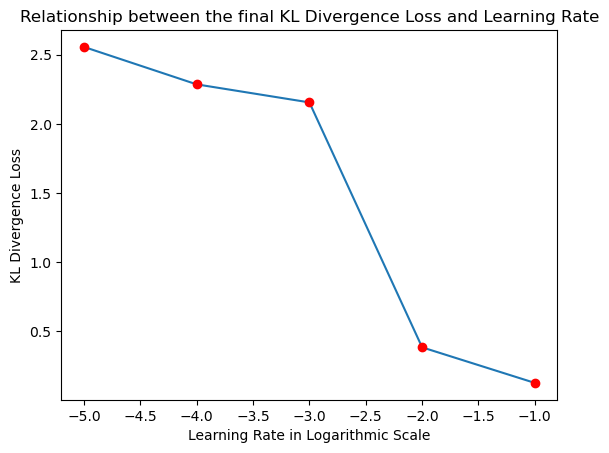

In [8]:
plt.plot([-5, -4, -3, -2, -1], losses, marker="o", markerfacecolor="red", markeredgecolor="red")
plt.title("Relationship between the final KL Divergence Loss and Learning Rate")
plt.ylabel("KL Divergence Loss")
plt.xlabel("Learning Rate in Logarithmic Scale")
plt.show()

We can see that as the learning rate increases logarithmically from $10^{-5}$ to $10^{-1}$, the final loss produced by this multilayer perceptron decreases. We can also see that at the largest learning rate in this range, the loss function converges more rapidly, as expected with a larger step size in descent. This shows that 0.1 is the optimal learning rate for this MLP.

1.1.2

In [9]:
# clearly learning rate = 0.1 is the optimal learning rate.

def accuracy(y_true, y_pred):
    # y_true is one hot encoded because I pass in the encoded matrix into sgd_opt
    # so we do argmax on it and y_pred
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    acc = np.mean(y_pred == y_true)
    
    return acc
    
def sgd_opt(x_train, x_test, y_train, y_test, lr=0.1, epochs=40, batch_size=128, print_out = True):
    if print_out:
        print(f"learning rate: {lr}")
    # initialise the weights and biases
    n_in = x_train.shape[1]
    n_hide = 200
    n_out = 10

    # goes into hidden 1
    var0 = 2 / (n_in + n_hide)
    W0 = np.random.randn(n_in, n_hide) * np.sqrt(var0)
    b0 = np.zeros(n_hide)

    # goes into hidden 2
    var1 = 2 / (n_hide + n_hide)
    W1 = np.random.randn(n_hide, n_hide) * np.sqrt(var1)
    b1 = np.zeros(n_hide)

    # goes into hidden 3
    var2 = var1
    W2 = np.random.randn(n_hide, n_hide) * np.sqrt(var2)
    b2 = np.zeros(n_hide)

    # goes into output
    var3 = 2 / (n_hide + n_out)
    W3 = np.random.randn(n_hide, n_out) * np.sqrt(var3)
    b3 = np.zeros(n_out)
    
    # create lists for loss and accuracy
    train_loss = []
    test_loss = []
        
    train_acc = []
    test_acc = []
    
    for epoch in range(epochs):
        # Shuffle the data
        idxs = np.random.permutation(len(x_train))
        x_train = x_train[idxs]
        y_train = y_train[idxs]
        
        # Mini-batch loop
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward pass
            h0 = x_batch
            a1 = dense(h0, W0, b0)
            h1 = softplus(a1)
            a2 = dense(h1, W1, b1)
            h2 = softplus(a2)
            a3 = dense(h2, W2, b2)
            h3 = softplus(a3)
            a4 = dense(h3, W3, b3)
            y_pred_batch = softmax(a4)
            
            # Backward pass
            delta4 = output_error(y_batch, y_pred_batch)
            delta3 = backpropagate(delta4, W3, a3)
            delta2 = backpropagate(delta3, W2, a2)
            delta1 = backpropagate(delta2, W1, a1)
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = grads(delta1, delta2, delta3, 
                                                                                           delta4, h0, h1, h2, h3)
            
            # Update weights and biases
            W0 = W0 - lr * grad_W0
            b0 = b0 - lr * grad_b0
            W1 = W1 - lr * grad_W1
            b1 = b1 - lr * grad_b1
            W2 = W2 - lr * grad_W2
            b2 = b2 - lr * grad_b2
            W3 = W3 - lr * grad_W3
            b3 = b3 - lr * grad_b3
        
        y_pred = mlp(x_train, W0, b0, W1, b1, W2, b2, W3, b3)
        y_pred_test = mlp(x_test, W0, b0, W1, b1, W2, b2, W3, b3)
        
        train_loss.append(kl_divergence(y_train, y_pred))
        test_loss.append(kl_divergence(y_test, y_pred_test))
        
        train_acc.append(accuracy(y_train, y_pred))
        test_acc.append(accuracy(y_test, y_pred_test))
        
        if print_out:
            print(f"Epoch {epoch+1}/{epochs}, training loss: {kl_divergence(y_train, y_pred):.4f}")
            print(f"Epoch {epoch+1}/{epochs}, test loss: {kl_divergence(y_test, y_pred_test):.4f}")
    
    # see 1.1.4 for explanation
    h0 = x_test[0: batch_size]
    a1 = dense(h0, W0, b0)
    h1 = softplus(a1)
    return train_loss, train_acc, test_loss, test_acc, h1

Y_test_MLP = one_hot_encode(y_test_MLP)
train_loss, train_acc, test_loss, test_acc, h1 = sgd_opt(X_train_MLP, X_test_MLP, Y_train_MLP, Y_test_MLP, 
                                                    print_out = True)

learning rate: 0.1
Epoch 1/40, training loss: 2.0836
Epoch 1/40, test loss: 2.0781
Epoch 2/40, training loss: 1.2232
Epoch 2/40, test loss: 1.2300
Epoch 3/40, training loss: 0.8358
Epoch 3/40, test loss: 0.8416
Epoch 4/40, training loss: 0.5803
Epoch 4/40, test loss: 0.5650
Epoch 5/40, training loss: 0.5031
Epoch 5/40, test loss: 0.4888
Epoch 6/40, training loss: 0.5082
Epoch 6/40, test loss: 0.4738
Epoch 7/40, training loss: 0.4327
Epoch 7/40, test loss: 0.4160
Epoch 8/40, training loss: 0.3721
Epoch 8/40, test loss: 0.3555
Epoch 9/40, training loss: 0.4034
Epoch 9/40, test loss: 0.3884
Epoch 10/40, training loss: 0.3824
Epoch 10/40, test loss: 0.3616
Epoch 11/40, training loss: 0.3300
Epoch 11/40, test loss: 0.3128
Epoch 12/40, training loss: 0.3486
Epoch 12/40, test loss: 0.3324
Epoch 13/40, training loss: 0.3265
Epoch 13/40, test loss: 0.3205
Epoch 14/40, training loss: 0.3221
Epoch 14/40, test loss: 0.3169
Epoch 15/40, training loss: 0.2716
Epoch 15/40, test loss: 0.2776
Epoch 16/

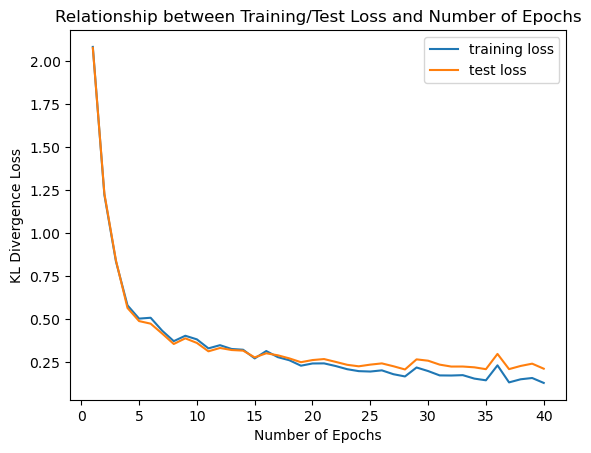

In [10]:
epoch_range = np.arange(1, 41)

plt.plot(epoch_range, train_loss, label="training loss")
plt.plot(epoch_range, test_loss, label="test loss")
plt.legend(loc="upper right")
plt.title("Relationship between Training/Test Loss and Number of Epochs")
plt.ylabel("KL Divergence Loss")
plt.xlabel("Number of Epochs")
plt.show()

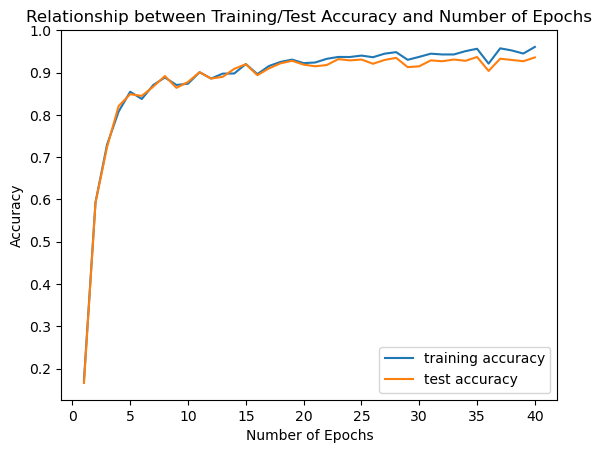

In [11]:
plt.plot(epoch_range, train_acc, label="training accuracy")
plt.plot(epoch_range, test_acc, label="test accuracy")
plt.legend(loc="lower right")
plt.title("Relationship between Training/Test Accuracy and Number of Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.show()

1.1.3

In [12]:
def sgd_50_neurons(x_train, x_test, y_train, y_test, lr=0.1, epochs=40, batch_size=128, print_out = True):
    if print_out:
        print(f"learning rate: {lr}")
    # initialise the weights and biases
    n_in = x_train.shape[1]
    # 50 neurons
    n_hide = 50
    n_out = 10

    # goes into hidden 1
    var0 = 2 / (n_in + n_hide)
    W0 = np.random.randn(n_in, n_hide) * np.sqrt(var0)
    b0 = np.zeros(n_hide)

    # goes into hidden 2
    var1 = 2 / (n_hide + n_hide)
    W1 = np.random.randn(n_hide, n_hide) * np.sqrt(var1)
    b1 = np.zeros(n_hide)

    # goes into hidden 3
    var2 = var1
    W2 = np.random.randn(n_hide, n_hide) * np.sqrt(var2)
    b2 = np.zeros(n_hide)

    # goes into output
    var3 = 2 / (n_hide + n_out)
    W3 = np.random.randn(n_hide, n_out) * np.sqrt(var3)
    b3 = np.zeros(n_out)
    
    # create lists for loss and accuracy
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(epochs):
        # Shuffle the data
        idxs = np.random.permutation(len(x_train))
        x_train = x_train[idxs]
        y_train = y_train[idxs]
        
        # Mini-batch loop
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward pass
            h0 = x_batch
            a1 = dense(h0, W0, b0)
            h1 = softplus(a1)
            a2 = dense(h1, W1, b1)
            h2 = softplus(a2)
            a3 = dense(h2, W2, b2)
            h3 = softplus(a3)
            a4 = dense(h3, W3, b3)
            y_pred_batch = softmax(a4)
            
            # Backward pass
            delta4 = output_error(y_batch, y_pred_batch)
            delta3 = backpropagate(delta4, W3, a3)
            delta2 = backpropagate(delta3, W2, a2)
            delta1 = backpropagate(delta2, W1, a1)
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = grads(delta1, delta2, delta3, 
                                                                                           delta4, h0, h1, h2, h3)
            
            # Update weights and biases
            W0 = W0 - lr * grad_W0
            b0 = b0 - lr * grad_b0
            W1 = W1 - lr * grad_W1
            b1 = b1 - lr * grad_b1
            W2 = W2 - lr * grad_W2
            b2 = b2 - lr * grad_b2
            W3 = W3 - lr * grad_W3
            b3 = b3 - lr * grad_b3
        
        y_pred = mlp(x_train, W0, b0, W1, b1, W2, b2, W3, b3)
        y_pred_test = mlp(x_test, W0, b0, W1, b1, W2, b2, W3, b3)
        
        train_loss.append(kl_divergence(y_train, y_pred))
        test_loss.append(kl_divergence(y_test, y_pred_test))
        
        train_acc.append(accuracy(y_train, y_pred))
        test_acc.append(accuracy(y_test, y_pred_test))
        
        if print_out:
            print(f"Epoch {epoch+1}/{epochs}, training accuracy: {accuracy(y_train, y_pred):.4f}")
            print(f"Epoch {epoch+1}/{epochs}, test accuracy: {accuracy(y_test, y_pred_test):.4f}")
    
    return train_acc, test_acc

train_acc_50, test_acc_50 = sgd_50_neurons(X_train_MLP, X_test_MLP, Y_train_MLP, Y_test_MLP)

learning rate: 0.1
Epoch 1/40, training accuracy: 0.4750
Epoch 1/40, test accuracy: 0.4650
Epoch 2/40, training accuracy: 0.5722
Epoch 2/40, test accuracy: 0.5960
Epoch 3/40, training accuracy: 0.7175
Epoch 3/40, test accuracy: 0.7240
Epoch 4/40, training accuracy: 0.7392
Epoch 4/40, test accuracy: 0.7300
Epoch 5/40, training accuracy: 0.8567
Epoch 5/40, test accuracy: 0.8660
Epoch 6/40, training accuracy: 0.8830
Epoch 6/40, test accuracy: 0.8880
Epoch 7/40, training accuracy: 0.8850
Epoch 7/40, test accuracy: 0.8860
Epoch 8/40, training accuracy: 0.8920
Epoch 8/40, test accuracy: 0.8840
Epoch 9/40, training accuracy: 0.8993
Epoch 9/40, test accuracy: 0.9000
Epoch 10/40, training accuracy: 0.9037
Epoch 10/40, test accuracy: 0.9000
Epoch 11/40, training accuracy: 0.9038
Epoch 11/40, test accuracy: 0.9010
Epoch 12/40, training accuracy: 0.8810
Epoch 12/40, test accuracy: 0.8680
Epoch 13/40, training accuracy: 0.9103
Epoch 13/40, test accuracy: 0.9060
Epoch 14/40, training accuracy: 0.917

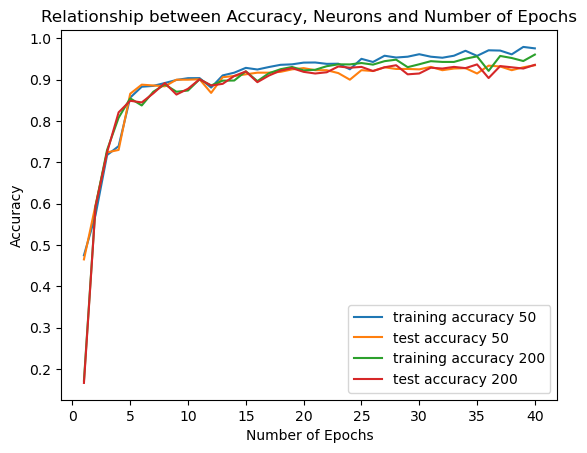

In [13]:
epoch_range = np.arange(1, 41)

plt.plot(epoch_range, train_acc_50, label="training accuracy 50")
plt.plot(epoch_range, test_acc_50, label="test accuracy 50")
plt.plot(epoch_range, train_acc, label="training accuracy 200")
plt.plot(epoch_range, test_acc, label="test accuracy 200")
plt.legend(loc="lower right")
plt.title("Relationship between Accuracy, Neurons and Number of Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.show()

We can see that the traning and test accuracy for 50 neurons is very similar to the training and test accuracy of the 200 neurons. The 50 neurons also took much less time to run and thus much less computational effort. Therefore, there could be an argument to choose 50 neurons over 200 neurons, especially given that it performs slightly better on the test set. However, because the difference is small we can't definitively say that the 200 neuron network is overfitting. The more neurons in the network the more complex the network is, allowing it to uncover information that may be missed by the 50 neuron network.

1.1.4

In [14]:
def sgd_dr(x_train, x_test, y_train, y_test, lr=0.8, dr=0.2, epochs=50, batch_size=128, print_out = True):
    if print_out:
        print(f"learning rate: {lr}")
    # initialise the weights and biases
    n_in = x_train.shape[1]
    n_hide = 200
    n_out = 10

    # goes into hidden 1
    var0 = 2 / (n_in + n_hide)
    W0 = np.random.randn(n_in, n_hide) * np.sqrt(var0)
    b0 = np.zeros(n_hide)

    # goes into hidden 2
    var1 = 2 / (n_hide + n_hide)
    W1 = np.random.randn(n_hide, n_hide) * np.sqrt(var1)
    b1 = np.zeros(n_hide)

    # goes into hidden 3
    var2 = var1
    W2 = np.random.randn(n_hide, n_hide) * np.sqrt(var2)
    b2 = np.zeros(n_hide)

    # goes into output
    var3 = 2 / (n_hide + n_out)
    W3 = np.random.randn(n_hide, n_out) * np.sqrt(var3)
    b3 = np.zeros(n_out)
    
    # create lists for loss and accuracy
    train_loss = []
    test_loss = []
        
    train_acc = []
    test_acc = []
    
    p = 1 - dr # probability of success (i.e. column of weights is preserved)
    
    for epoch in range(epochs):
        # Shuffle the data
        idxs = np.random.permutation(len(x_train))
        x_train = x_train[idxs]
        y_train = y_train[idxs]
        
        # Mini-batch loop
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # forward pass with dropout
            # instead of matrix multiplying the weights we will multiply the hs and deltas
            # if we zero out the rows of the h's it's the same as zeroing out the columns of W
            # this way we will be more numerically stable
            h0 = x_batch
            a1 = dense(h0, W0, b0)
        
            h1 = softplus(a1)
            z1 = np.random.binomial(1, p, h1.shape) / p
            h1 *= z1
            
            a2 = dense(h1, W1, b1)
            h2 = softplus(a2)
            z2 = np.random.binomial(1, p, h2.shape) / p
            h2 *= z2
            
            a3 = dense(h2, W2, b2)
            h3 = softplus(a3)
            z3 = np.random.binomial(1, p ,h3.shape) / p
            h3 *= z3
            
            a4 = dense(h3, W3, b3)
            y_pred_batch = softmax(a4)
            
            # Backward pass
            delta4 = output_error(y_batch, y_pred_batch)
            delta3 = backpropagate(delta4, W3, a3)
            delta3 *= z3
            delta2 = backpropagate(delta3, W2, a2)
            delta2 *= z2
            delta1 = backpropagate(delta2, W1, a1)
            delta1 *= z1
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = grads(delta1, delta2, delta3, 
                                                                                           delta4, h0, h1, h2, h3)
            
            # Update weights and biases
            W0 = W0 - lr * grad_W0
            b0 = b0 - lr * grad_b0
            W1 = W1 - lr * grad_W1
            b1 = b1 - lr * grad_b1
            W2 = W2 - lr * grad_W2
            b2 = b2 - lr * grad_b2
            W3 = W3 - lr * grad_W3
            b3 = b3 - lr * grad_b3
        
        # don't apply dropout when predicting
        y_pred = mlp(x_train, W0, b0, W1, b1, W2, b2, W3, b3)
        y_pred_test = mlp(x_test, W0, b0, W1, b1, W2, b2, W3, b3)
        
        train_loss.append(kl_divergence(y_train, y_pred))
        test_loss.append(kl_divergence(y_test, y_pred_test))
        
        train_acc.append(accuracy(y_train, y_pred))
        test_acc.append(accuracy(y_test, y_pred_test))
        
        if print_out:
            print(f"Epoch {epoch+1}/{epochs}, training loss: {kl_divergence(y_train, y_pred):.4f}")
            print(f"Epoch {epoch+1}/{epochs}, test loss: {kl_divergence(y_test, y_pred_test):.4f}")
    
    # 1.1.4
    h0 = x_test[0: batch_size]
    a1 = dense(h0, W0, b0)
    h1 = softplus(a1)
    return train_loss, train_acc, test_loss, test_acc, h1


train_loss_dr, train_acc_dr, test_loss_dr, test_acc_dr, h1_dr = sgd_dr(X_train_MLP, X_test_MLP, 
                                                                 Y_train_MLP, Y_test_MLP, print_out=True)

learning rate: 0.8
Epoch 1/50, training loss: 2.2529
Epoch 1/50, test loss: 2.2502
Epoch 2/50, training loss: 1.5688
Epoch 2/50, test loss: 1.5617
Epoch 3/50, training loss: 0.9520
Epoch 3/50, test loss: 0.9407
Epoch 4/50, training loss: 0.6337
Epoch 4/50, test loss: 0.6044
Epoch 5/50, training loss: 0.4978
Epoch 5/50, test loss: 0.4713
Epoch 6/50, training loss: 0.4119
Epoch 6/50, test loss: 0.4261
Epoch 7/50, training loss: 0.3697
Epoch 7/50, test loss: 0.3609
Epoch 8/50, training loss: 0.3733
Epoch 8/50, test loss: 0.3917
Epoch 9/50, training loss: 0.2939
Epoch 9/50, test loss: 0.3266
Epoch 10/50, training loss: 0.2755
Epoch 10/50, test loss: 0.2989
Epoch 11/50, training loss: 0.2202
Epoch 11/50, test loss: 0.2472
Epoch 12/50, training loss: 0.1995
Epoch 12/50, test loss: 0.2537
Epoch 13/50, training loss: 0.2083
Epoch 13/50, test loss: 0.2578
Epoch 14/50, training loss: 0.1851
Epoch 14/50, test loss: 0.2542
Epoch 15/50, training loss: 0.2004
Epoch 15/50, test loss: 0.2735
Epoch 16/

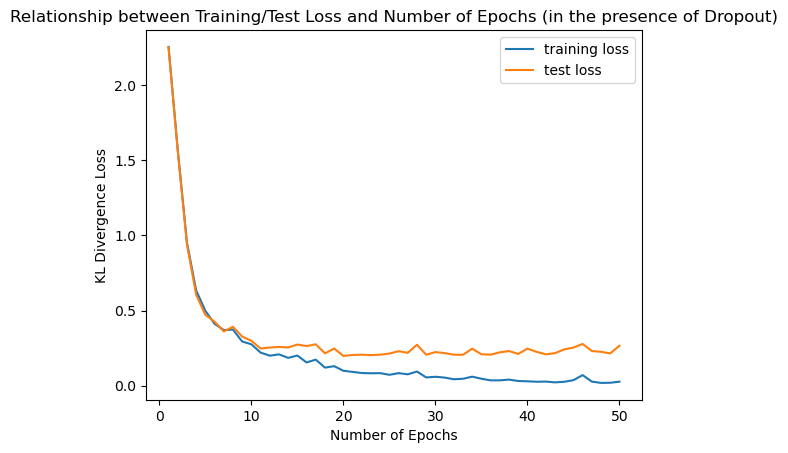

In [15]:
epoch_range_dr = np.arange(1, 51)

plt.plot(epoch_range_dr, train_loss_dr, label="training loss")
plt.plot(epoch_range_dr, test_loss_dr, label="test loss")
plt.legend(loc="upper right")
plt.title("Relationship between Training/Test Loss and Number of Epochs (in the presence of Dropout)")
plt.ylabel("KL Divergence Loss")
plt.xlabel("Number of Epochs")
plt.show()

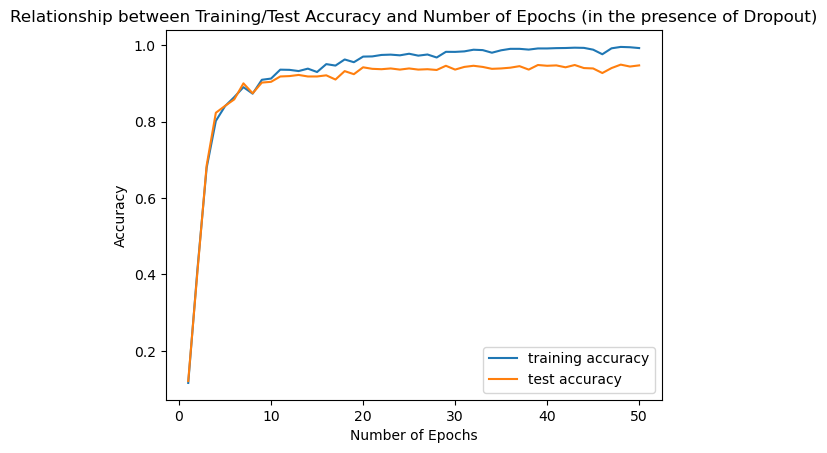

In [16]:
epoch_range_dr = np.arange(1, 51)

plt.plot(epoch_range_dr, train_acc_dr, label="training accuracy")
plt.plot(epoch_range_dr, test_acc_dr, label="test accuracy")
plt.legend(loc="lower right")
plt.title("Relationship between Training/Test Accuracy and Number of Epochs (in the presence of Dropout)")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.show()

We can see that the training and test loss are lower than in `1.1.2`, plus the training and test accuracies are higher. The graphs above show steeper descent and incline for loss and accuracy respectively, which indicate quicker convergence. Ultimately, we can conclude that in the presence of dropout we get a model which trains and generalises better than the 200-nueron model. This is potentially because the neurons no longer depend on other neurons being in the model.

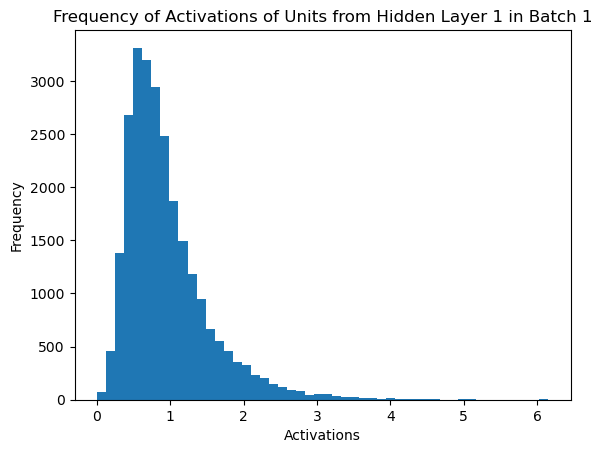

In [17]:
# here we train on training set as usual but then get the activation from the first batch of the test data set.
# and plot them in a histogram.
plt.hist(h1.flatten(), bins=50, range=(np.min(h1), np.max(h1)))
plt.title("Frequency of Activations of Units from Hidden Layer 1 in Batch 1")
plt.ylabel("Frequency")
plt.xlabel("Activations")
plt.show()

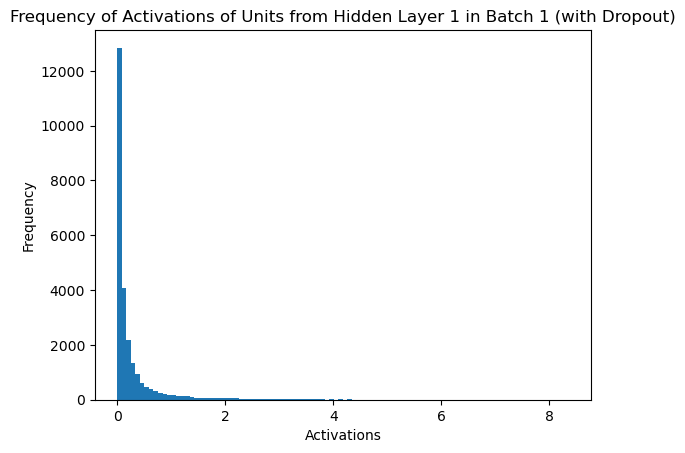

In [18]:
plt.hist(h1_dr.flatten(), bins=100, range=(np.min(h1_dr), np.max(h1_dr)))
plt.title("Frequency of Activations of Units from Hidden Layer 1 in Batch 1 (with Dropout)")
plt.ylabel("Frequency")
plt.xlabel("Activations")
plt.show()

We can see that with dropout there are a higher number of smaller activations from the first hidden layer. This is as expected, because some weights will have been set to zero. Moreover, because the activations are much closer to zero in the dropout model, the subsequent weights and activations will also be closer to zero. This severly reduces overfitting making the model perform better on unseen data.

#### 1.2 Dimensionality reduction (20 marks)

1.2.1

In [19]:
train_PCA = pd.read_csv("./MNIST_train_noisy", sep=" ", header=None).to_numpy()
test_PCA = pd.read_csv("./MNIST_test_noisy", sep=" ", header=None).to_numpy()
X_PCA = train_PCA.reshape(-1, 28 * 28) / 255.

# we have to standardise everytime we use pca.
def standardise_PCA(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar, mu, std

X_PCA_train, _, _ = standardise_PCA(X_PCA)

In [20]:
# we are allowed to use scipy
from scipy.sparse import linalg

def pca_function(X , m):

    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, m, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues= eigenvalues[sorted_index]
    eigenvectors= eigenvectors[:,sorted_index ]

    # transform our data to get the first m pixels (for each image) instead of all the pixels in the data set.
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

In [21]:
m_range = np.arange(0, 501, 1)
m_range[0] = 1

explained_vars = np.array([])
for m in m_range:
    X_pca, eigenvectors, eigenvalues = pca_function(X_PCA_train, m)
    C = 1.0/(len(X_PCA_train)-1) * np.dot(X_PCA_train.T, X_PCA_train)
    all_eigenvalues, _ = np.linalg.eig(C)
    total_variance = abs(all_eigenvalues.sum())
    
    # get the total proportion of variance explained by the principcal eigenvalues
    explained_variance = sum(eigenvalues) / total_variance
    explained_vars = np.append(explained_vars, explained_variance)

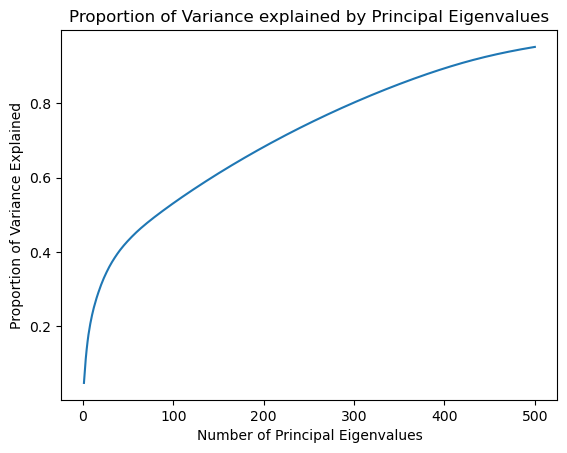

In [22]:
plt.plot(m_range, explained_vars)
plt.title("Proportion of Variance explained by Principal Eigenvalues")
plt.ylabel("Proportion of Variance Explained")
plt.xlabel("Number of Principal Eigenvalues")
plt.show()

In [23]:
ind_70 = np.argmax(explained_vars[explained_vars < 0.7]) + 1
val_70 = m_range[ind_70]
ind_80 = np.argmax(explained_vars[explained_vars < 0.8]) + 1
val_80 = m_range[ind_80]
ind_90 = np.argmax(explained_vars[explained_vars < 0.9]) + 1
val_90 = m_range[ind_90]

print(f"Values {val_70}, {val_80} and {val_90} explain 70%, 80% and 90% of the variance respectively. ")

Values 213, 298 and 408 explain 70%, 80% and 90% of the variance respectively. 


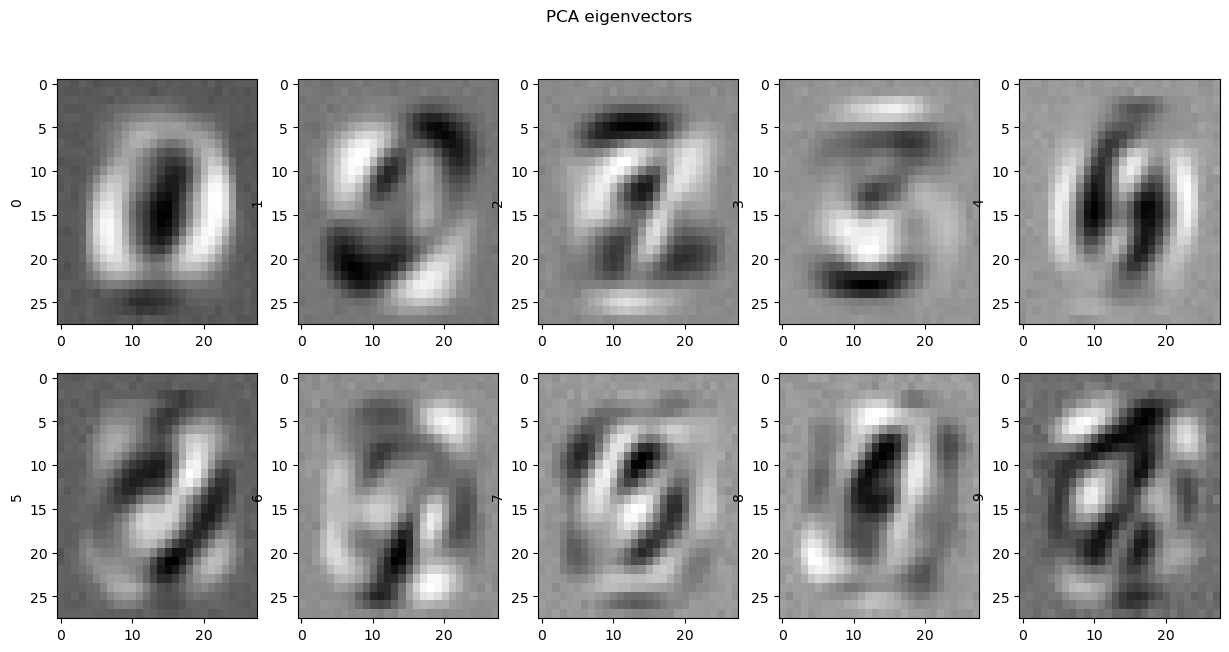

In [24]:
X_pca, eigenvectors, eigenvalues = pca_function(X_PCA_train, 10)

nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15, 7))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors[:, i].reshape([28,28]), aspect="auto", cmap="gray")
    ax.set_ylabel(str(i))

fig.suptitle('PCA eigenvectors')
plt.show()

1.2.2

In [25]:
# we have to use min-max normalisation when working with NMF.
def normalize_nmf(X):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X))
    return X_norm

X_NMF_train = normalize_nmf(train_PCA.reshape(-1, 28 * 28)/255.)

Convergence achieved within the number of iterations.


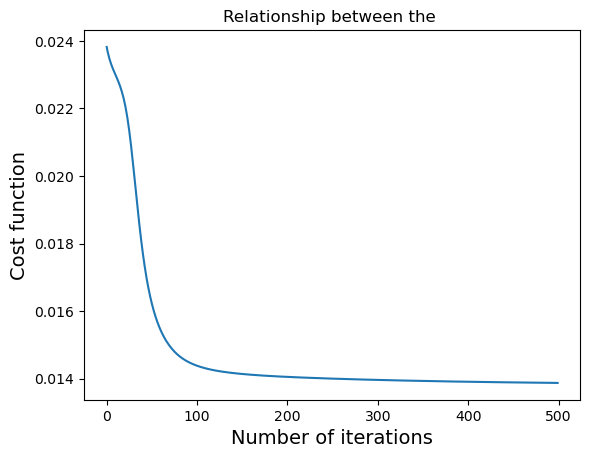

In [26]:
# lets define a cost matrix based on Euclidean distance
def cost(X,W,H):
    
    # computes the Mean Square Error 
  
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H)
    
    # Compute the Euclidean distance-based objective function
    cost_value = (diff * diff).sum() / (X.shape[0] * X.shape[1])
    
    # Here we have also normalized the sum by the number of terms in the sum (but it's not necessary).
    
    return cost_value

# perform the NMF algorithm with m = 10 computing the cost and appending to a list.
m = 10

# m x P matrix interpreted as the basis set, where m is the number of components, 
# P the number of descriptors of the data

H = np.random.rand(m, X_NMF_train.shape[1])

# N x m components matrix, usually interpreted as the coefficients, N is the number of data
W = np.random.rand(X_NMF_train.shape[0], m)

# set the number of iterations
n_iters = 500
pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

# empty list 
cost_values = []

# loop over the n iterations
convergence = False
for i in range(n_iters):

    # compute the update on H
    H = H * ((W.T.dot(X_NMF_train))/(W.T.dot(W.dot(H)) + pseudo_count))

    # compute the update on W
    W = W * ((X_NMF_train.dot(H.T))/(W.dot(H.dot(H.T)) + pseudo_count)) 
    
    # compute the cost and append to list
    cost_values.append(cost(X_NMF_train, W, H))
    
    if cost(X_NMF_train, W, H) - cost_values[-1] < 1e-100:
        convergence = True

# prove that we get convergence
if convergence:
    print("Convergence achieved within the number of iterations.")

plt.plot(cost_values)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Cost function', fontsize=14)
plt.title("Relationship between the ")
plt.show()

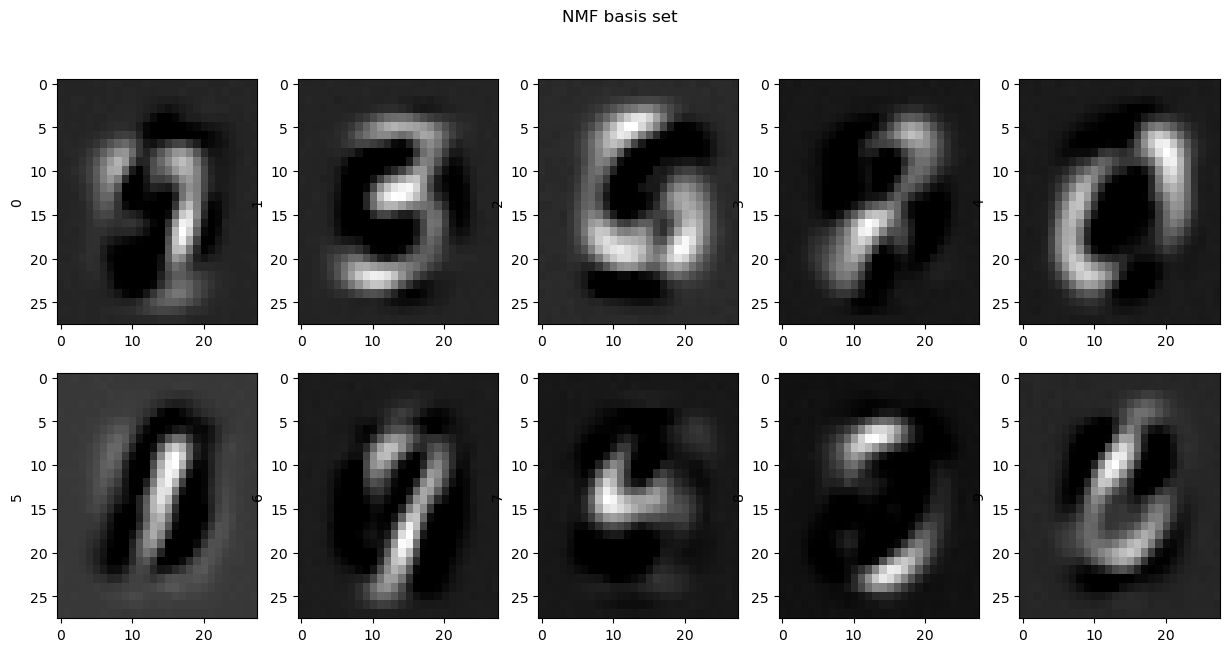

In [27]:
nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15, 7))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(H[i, :].reshape([28,28]), aspect="auto", cmap="gray")
    ax.set_ylabel(str(i))

fig.suptitle('NMF basis set')
plt.show()

NMF gives a clearer set of digits compared to PCA. The main difference is that NMF discovers non-negative features whereas PCA expresses the reduced representation as a linear combination of informative features. In this case, we are working with grayscale images or in the non-negative setting, so this could by why NMF gives slightly clearer ouputs. 

1.2.3

In order to reconstruct the test image through PCA, we will use the SVD formula from the lecture notes. $\mathcal{X} = X_{test} V V^T$ where $\mathcal{X}$ is the centered data, $X_{test}$ is the test data set and $V$ is the eigenvector matrix. We can reconstruct the test image via NMF using the analogous form which replaces $V$ with $H^T$, where $H$ is the basis set.

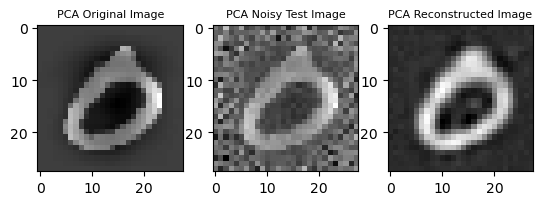

In [28]:
# PCA: recall we can get the approximate image using SVD by X @ V @ V.T
X_pca, eigenvectors, eigenvalues = pca_function(X_PCA_train, 100)

# V is the eigenvectors of X.T @ X which we calulcated in the pca_function
projection = eigenvectors @ eigenvectors.T

# get standardised noisy data
X_PCA_test, mu_test, std_test = standardise_PCA(test_PCA.reshape(-1, 28 * 28) / 255.)

# read in clean original test data
orig_PCA = pd.read_csv("./MNIST_test.csv").iloc[:, 1:].to_numpy()
X_PCA_orig, _, _ = standardise_PCA(orig_PCA.reshape(-1, 28 * 28) / 255.)

# use V to get the reconstructed image.
X_PCA_recon = X_PCA_test @ projection

# unstandardise data
X_PCA_recon = np.asarray(X_PCA_recon) * std_test + mu_test

# we are going to visualise the first image in the clean data, the noisy data and then the reconstructed data

fig, axs = plt.subplots(nrows=1, ncols=3)

axs[0].imshow(X_PCA_orig[0, :].reshape([28, 28]), cmap="gray")
axs[1].imshow(X_PCA_test[0, :].reshape([28, 28]), cmap="gray")
axs[2].imshow(X_PCA_recon[0, :].reshape([28, 28]), cmap="gray")
axs[0].set_title("PCA Original Image", fontsize=8)
axs[1].set_title("PCA Noisy Test Image", fontsize=8)
axs[2].set_title("PCA Reconstructed Image", fontsize=8)
plt.show()

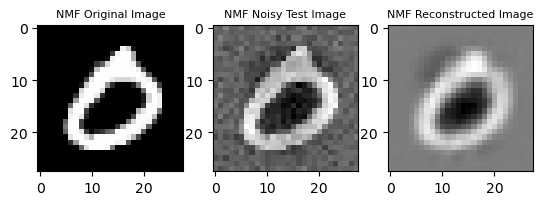

In [29]:
# define a function which trains NMF for an X and returns W and H
def NMF(X, m):
    # m x P matrix interpreted as the basis set, where m is the number of components, 
    # P the number of descriptors of the data
    H = np.random.rand(m, X.shape[1])

    # N x m components matrix, usually interpreted as the coefficients, N is the number of data
    W = np.random.rand(X.shape[0], m)

    # set the number of iterations
    n_iters = 500
    pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

    # empty list 
    cost_values = []

    # loop over the n iterations
    convergence = False
    for i in range(n_iters):

        # compute the update on H
        H = H * ((W.T.dot(X))/(W.T.dot(W.dot(H)) + pseudo_count))

        # compute the update on W
        W = W * ((X.dot(H.T))/(W.dot(H.dot(H.T)) + pseudo_count)) 

        # compute the cost and append to list
        cost_values.append(cost(X, W, H))
        
        # check for convergence before iterations have ended.
        if cost(X, W, H) - cost_values[-1] < 1e-100:
            convergence = True
    
    return W, H

W, H = NMF(X_NMF_train, 100)

# we have to work with centered data.
X_NMF_test = normalize_nmf(test_PCA.reshape(-1, 28 * 28)) - np.mean(X_NMF_train, axis=0)

X_NMF_orig = normalize_nmf(orig_PCA.reshape(-1, 28 * 28))

# analogous SVD reconstruction
X_NMF_recon = X_NMF_test @ (H.T @ H)

fig, axs = plt.subplots(nrows=1, ncols=3)

axs[0].imshow(X_NMF_orig[0, :].reshape([28, 28]), cmap="gray")
axs[1].imshow(X_NMF_test[0, :].reshape([28, 28]), cmap="gray")
axs[2].imshow(X_NMF_recon[0, :].reshape([28, 28]), cmap="gray")
axs[0].set_title("NMF Original Image", fontsize=8)
axs[1].set_title("NMF Noisy Test Image", fontsize=8)
axs[2].set_title("NMF Reconstructed Image", fontsize=8)
plt.show()

Both PCA and NMF reconstruction give similar results. However, I think that in this case the PCA reconstruction was better able to pick up the colour of the background compared the NMF reconstruction. 

1.2.4

In [30]:
# MSE function
def mse(predict, actual):
    return np.square(predict - actual).sum(axis=1).mean()

#get data
X_PCA = train_PCA.reshape(-1, 28 * 28) / 255.
X_PCA_train, _, _ = standardise_PCA(X_PCA)
X_PCA_test, mu_test, std_test = standardise_PCA(test_PCA.reshape(-1, 28 * 28) / 255.)
orig_PCA = pd.read_csv("./MNIST_test.csv").iloc[:, 1:].to_numpy()
X_PCA_orig, _, _ = standardise_PCA(orig_PCA.reshape(-1, 28 * 28) / 255.)

# define reconstuction
def recon_PCA(X, X_test, m):
    # PCA: recall we can get the approximate image using SVD by X @ V @ V.T
    X_pca, eigenvectors, eigenvalues = pca_function(X, m)

    # V is the eigenvectors of X.T @ X which we calulcated in the pca_function
    projection = eigenvectors @ eigenvectors.T

    # use V to get the reconstructed image.
    X_pred = X_test @ projection
    
    return X_pred.reshape(-1,784)

m_range = np.arange(5, 405, 5)
MSE_arr_orig = np.array([])
MSE_arr_noisy = np.array([])

for m in m_range:
    X_pred = recon_PCA(X_PCA_train, X_PCA_test, m)
    MSE_orig = mse(X_pred, X_PCA_orig)
    MSE_noisy = mse(X_pred, X_PCA_test)
    MSE_arr_orig = np.append(MSE_arr_orig, MSE_orig)
    MSE_arr_noisy = np.append(MSE_arr_noisy, MSE_noisy)

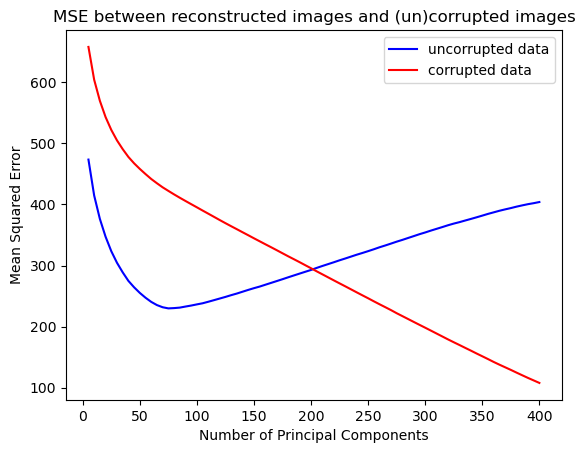

In [31]:
plt.plot(m_range, MSE_arr_orig, color="blue")
plt.plot(m_range, MSE_arr_noisy, color="red")
plt.title("MSE between reconstructed images and (un)corrupted images")
plt.legend(labels=["uncorrupted data", "corrupted data"], loc="upper right")
plt.xlabel("Number of Principal Components")
plt.ylabel("Mean Squared Error")
plt.show()

The graph above shows the mean-squared error between the reconstructed images and both the corrupted and uncorrupted images decreases initially. However after roughly 75 principal components, the mean-squared error between the reconstructed and the uncorrupted images begins to increase. Whereas the MSE with the corrupted images continues to decrease. This shows that, there is an optimal number of principal components where the reconstructed image best represents the uncorrupted and corrupted images. 

The aim is to minimise the MSE between the uncorrupted image while maximising the MSE between the corrupted image. This is because we want the reconstructed image to be as close to the original but not have as much noise as the corrupted image. Using this we may choose 75 principal components which represents the trough in the MSE graph.

This can be seen by the images below. The images improve when we increase from 10 to 40 and then to 100 components. However, the background of the reconstructed image with 200 components is more grainy and thus noisy compared to 100 components. It is easy to understand that the more principal components we use, the more likely we are to just recover the noisy data. 

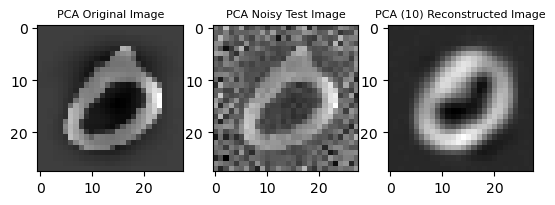

In [32]:
fig, axs = plt.subplots(1, 3)

X_pred_10 = recon_PCA(X_PCA_train, X_PCA_test, 10)[0, :] * std_test + mu_test
X_pred_40 = recon_PCA(X_PCA_train, X_PCA_test, 40)[0, :] * std_test + mu_test
X_pred_100 = recon_PCA(X_PCA_train, X_PCA_test, 100)[0, :] * std_test + mu_test
X_pred_200 = recon_PCA(X_PCA_train, X_PCA_test, 200)[0, :] * std_test + mu_test
 
axs[0].imshow(X_PCA_orig[0, :].reshape([28, 28]), cmap="gray")
axs[1].imshow(X_PCA_test[0, :].reshape([28, 28]), cmap="gray")
axs[2].imshow(X_pred_10.reshape([28, 28]), cmap="gray")
axs[0].set_title("PCA Original Image", fontsize=8)
axs[1].set_title("PCA Noisy Test Image", fontsize=8)
axs[2].set_title("PCA (10) Reconstructed Image", fontsize=8)
plt.show()

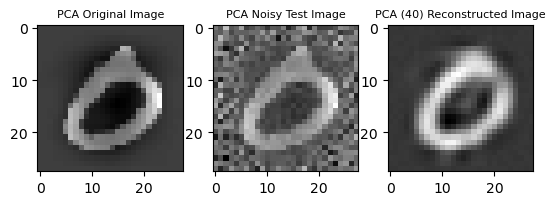

In [33]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(X_PCA_orig[0, :].reshape([28, 28]), cmap="gray")
axs[1].imshow(X_PCA_test[0, :].reshape([28, 28]), cmap="gray")
axs[2].imshow(X_pred_40.reshape([28, 28]), cmap="gray")
axs[0].set_title("PCA Original Image", fontsize=8)
axs[1].set_title("PCA Noisy Test Image", fontsize=8)
axs[2].set_title("PCA (40) Reconstructed Image", fontsize=8)
plt.show()

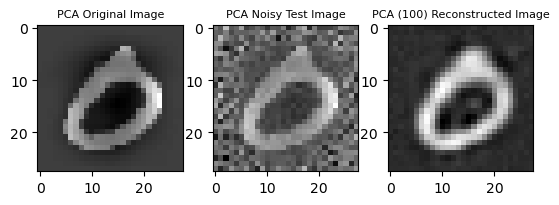

In [34]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(X_PCA_orig[0, :].reshape([28, 28]), cmap="gray")
axs[1].imshow(X_PCA_test[0, :].reshape([28, 28]), cmap="gray")
axs[2].imshow(X_pred_100.reshape([28, 28]), cmap="gray")
axs[0].set_title("PCA Original Image", fontsize=8)
axs[1].set_title("PCA Noisy Test Image", fontsize=8)
axs[2].set_title("PCA (100) Reconstructed Image", fontsize=8)
plt.show()

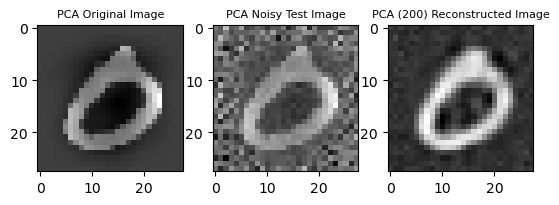

In [35]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(X_PCA_orig[0, :].reshape([28, 28]), cmap="gray")
axs[1].imshow(X_PCA_test[0, :].reshape([28, 28]), cmap="gray")
axs[2].imshow(X_pred_200.reshape([28, 28]), cmap="gray")
axs[0].set_title("PCA Original Image", fontsize=8)
axs[1].set_title("PCA Noisy Test Image", fontsize=8)
axs[2].set_title("PCA (200) Reconstructed Image", fontsize=8)
plt.show()

#### 1.3 Gaussian Mixture Models (20 marks)
1.3.1

In [36]:
X_train_GMM = train_MLP.iloc[:1000, 1:].to_numpy() / 255.

# we have to standardise when performing pca
X_train_GMM, _, _ = standardise_PCA(X_train_GMM)

# get top 5 principal components
X_GMM_pca, evecs_GMM, evals_GMM = pca_function(X_train_GMM, 5)

# we are allowed to use scipy
from scipy.stats import multivariate_normal 

class GMModel:
    """Struct to define Gaussian Mixture Model"""
    """:param dim: number of mixture components"""
    """:param weights: mixture weights"""
    """:param mu: mixture component means for each cluster"""
    """:param sigma: mixture component covariance matrix for each cluster"""
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 

gmm = GMModel(X_GMM_pca, 10)

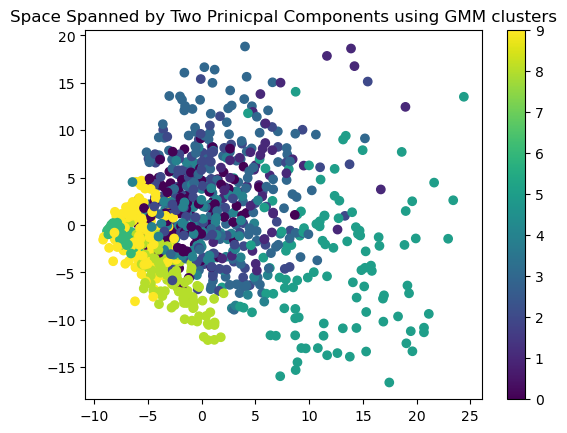

In [37]:
def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i])
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
    return weights

def fitStep(gmm,X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X) ### <- fill in
    gmm.phi = weights.mean(axis=0)
      
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

def predict(gmm, X):
    """Performs hard clustering"""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1)

for _ in range(100):
    fitStep(gmm, X_GMM_pca)
clusters = predict(gmm, X_GMM_pca)


plt.scatter(X_GMM_pca[:, 0], X_GMM_pca[:, 1], c=clusters, cmap='viridis', zorder=2)
plt.title("Space Spanned by Two Prinicpal Components using GMM clusters")
plt.colorbar()
plt.show()

1.3.2

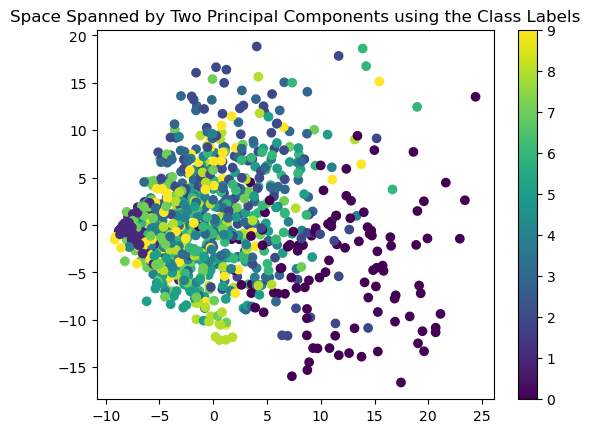

In [38]:
# visualise the space spanned by the prinicipal components using the class as the label
classes_GMM = y_train_MLP
labels = classes_GMM[:1000]

plt.scatter(X_GMM_pca[:, 0], X_GMM_pca[:, 1], c=labels, cmap='viridis', zorder=2)
plt.title("Space Spanned by Two Principal Components using the Class Labels")
plt.colorbar()
plt.show()

In [39]:
# iterate over the classes of each data point and assign that class to a cluster
# to do this find which clustering label maximises the log-likelihood of the mixture components at the data point.

def log_like_label(gmm, X, clusters):
    # create a matrix of the log likelihoods of each cluster for all data points in a label
    
    n_clusters = len(clusters)
    n_samples, n_features = X.shape
    log_like_mat = np.zeros((n_samples, n_clusters))
    
    for i, cluster in enumerate(clusters):
        mu = np.array(gmm.mu)[cluster, :]
        sigma = np.array(gmm.sigma)[cluster, :, :]
        
        distribution = multivariate_normal(mean=mu,cov=sigma)
        log_like_arr = distribution.logpdf(X)
        
        # fill in the corresponding column of log_like_mat
        log_like_mat[:, i] = log_like_arr
        
    # sum row-wise to get the "total" log-likelihoods in a 1 x n_clusters array
    log_like_tot = np.sum(log_like_mat, axis=0)
    
    return log_like_tot


label_map = []

for label in np.unique(labels):
    X_label = X_GMM_pca[labels == label]
    log_like_tot = log_like_label(gmm, X_label, np.unique(clusters))
    
    # find the largest log likelihood which corresponds to the best cluster.
    cluster_ind = np.argmax(log_like_tot)
    label_map.append(cluster_ind)

print("The label to cluster index map is: {}".format(label_map))

The label to cluster index map is: [5, 6, 3, 3, 2, 3, 1, 2, 3, 2]


1.3.3

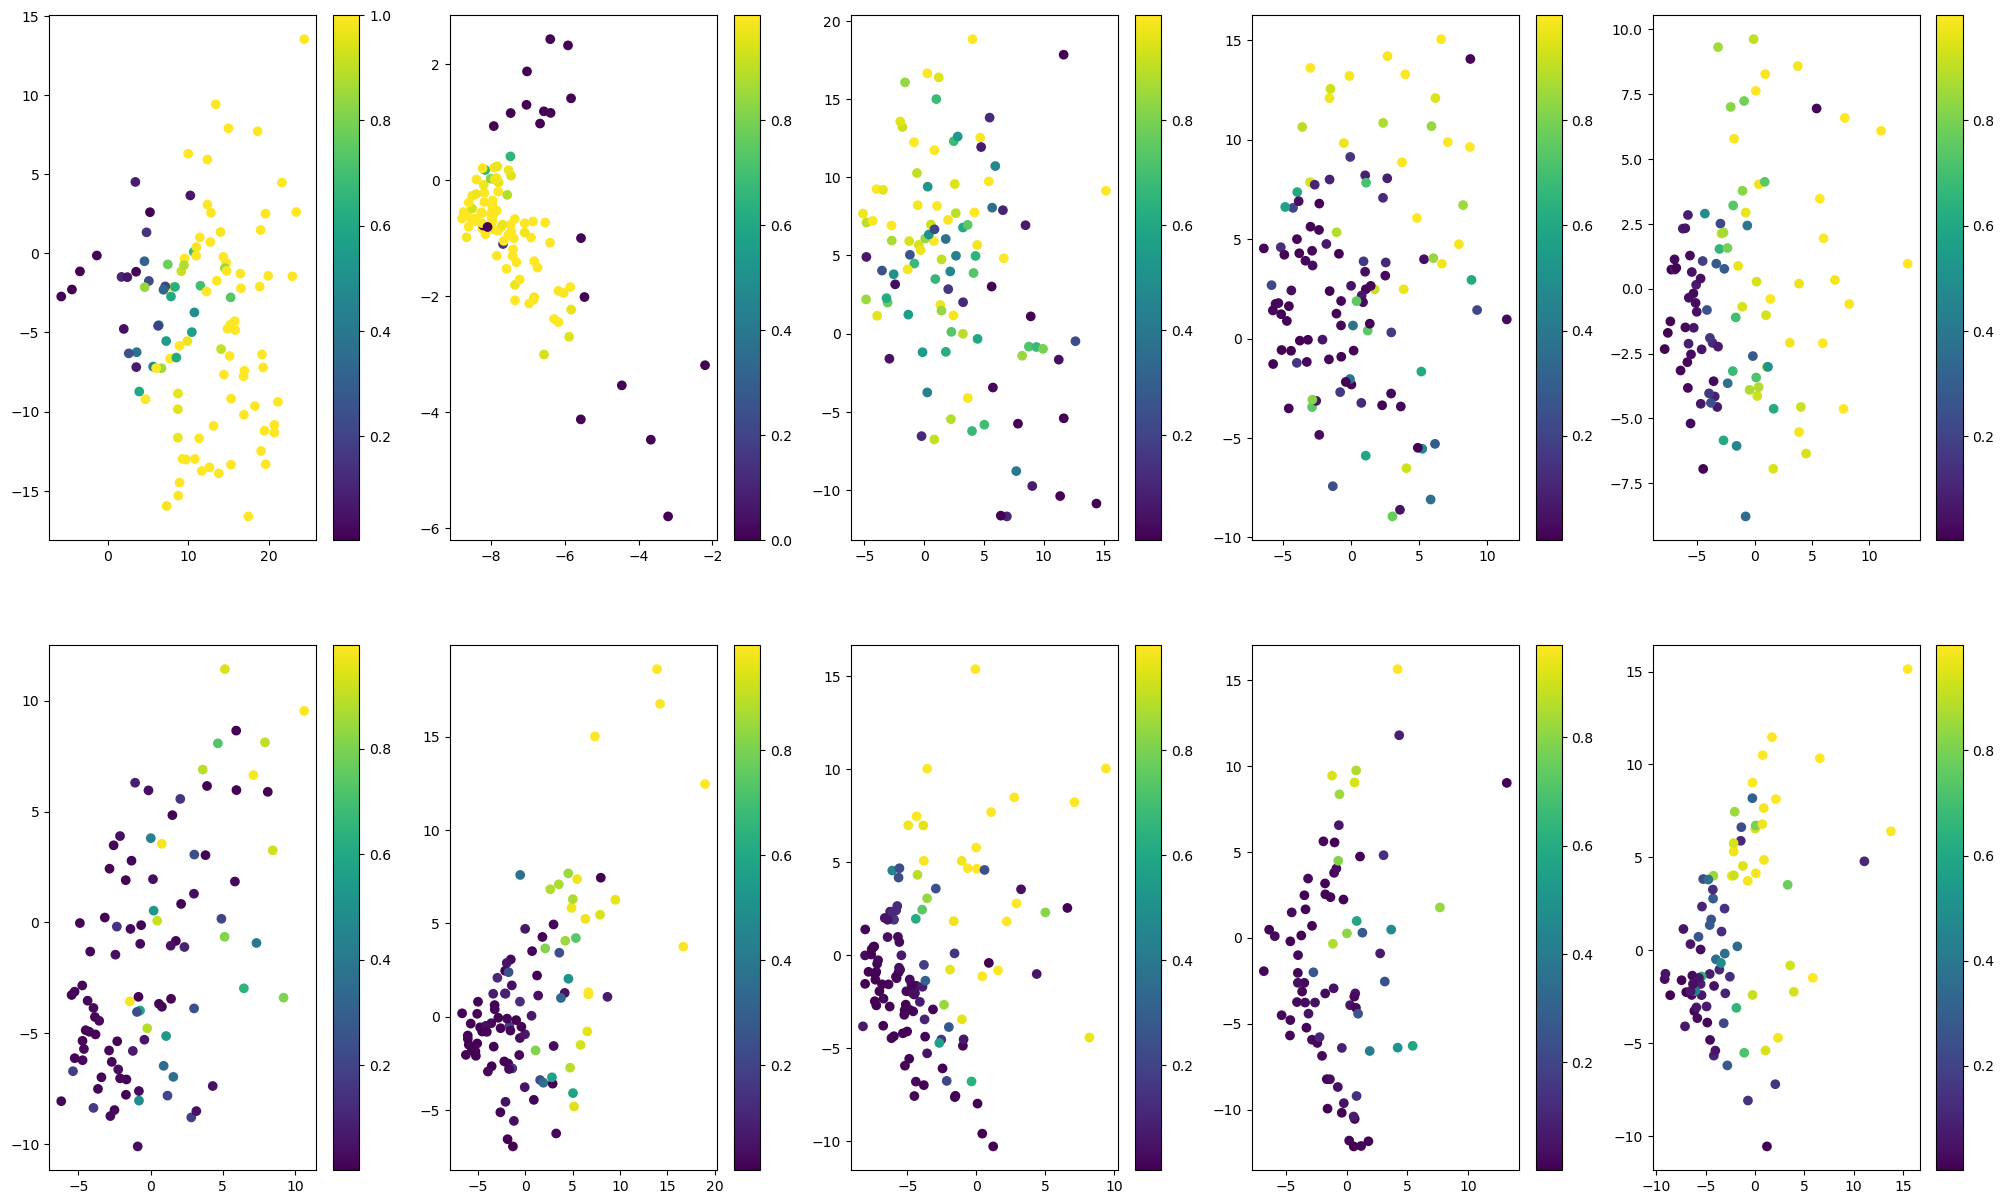

In [40]:
plt.figure(figsize = (25,15))

for ind, lab in enumerate(label_map):
    # get the weights from the best cluster for the data points which correspond to digit index
    plt.subplot(2, 5, ind+1)
    weights = cluster_probabilities(gmm, X_GMM_pca)[labels==ind, lab]
    plt.scatter(X_GMM_pca[labels==ind, 0], X_GMM_pca[labels==ind, 1], c=weights)
    plt.colorbar()

plt.show()

In the plots above we have a fair few purple dots which represent that these points from that class have a close to zero probability of being assigned to that cluster. However class 2 is the exception where a lot of the data points have a high probability of being put into cluster 8. Ultimately, I think this plot shows that the GMM doesn't perform that great in this scenario.

1.3.4

In [41]:
gmm_5 = GMModel(X_GMM_pca, 5)
gmm_8 = GMModel(X_GMM_pca, 8)

for _ in range(100):
    fitStep(gmm_5, X_GMM_pca)
    fitStep(gmm_8, X_GMM_pca)
clusters_5 = predict(gmm_5, X_GMM_pca)
clusters_8 = predict(gmm_8, X_GMM_pca)


label_map_5 = []
label_map_8 = []

for label in np.unique(labels):
    X_label = X_GMM_pca[labels == label]
    
    log_5 = log_like_label(gmm_5, X_label, np.unique(clusters_5))
    ind_5 = np.argmax(log_5)
    label_map_5.append(ind_5)
    
    log_8 = log_like_label(gmm_8, X_label, np.unique(clusters_8))
    ind_8 = np.argmax(log_8)
    label_map_8.append(ind_8)
    

print("The label to cluster map for 5 mixture models: {}".format(label_map_5))
print("\nThe label to cluster map for 8 mixture models: {}".format(label_map_8))

The label to cluster map for 5 mixture models: [3, 0, 2, 2, 1, 4, 3, 1, 4, 2]

The label to cluster map for 8 mixture models: [6, 3, 7, 2, 0, 1, 7, 0, 6, 2]


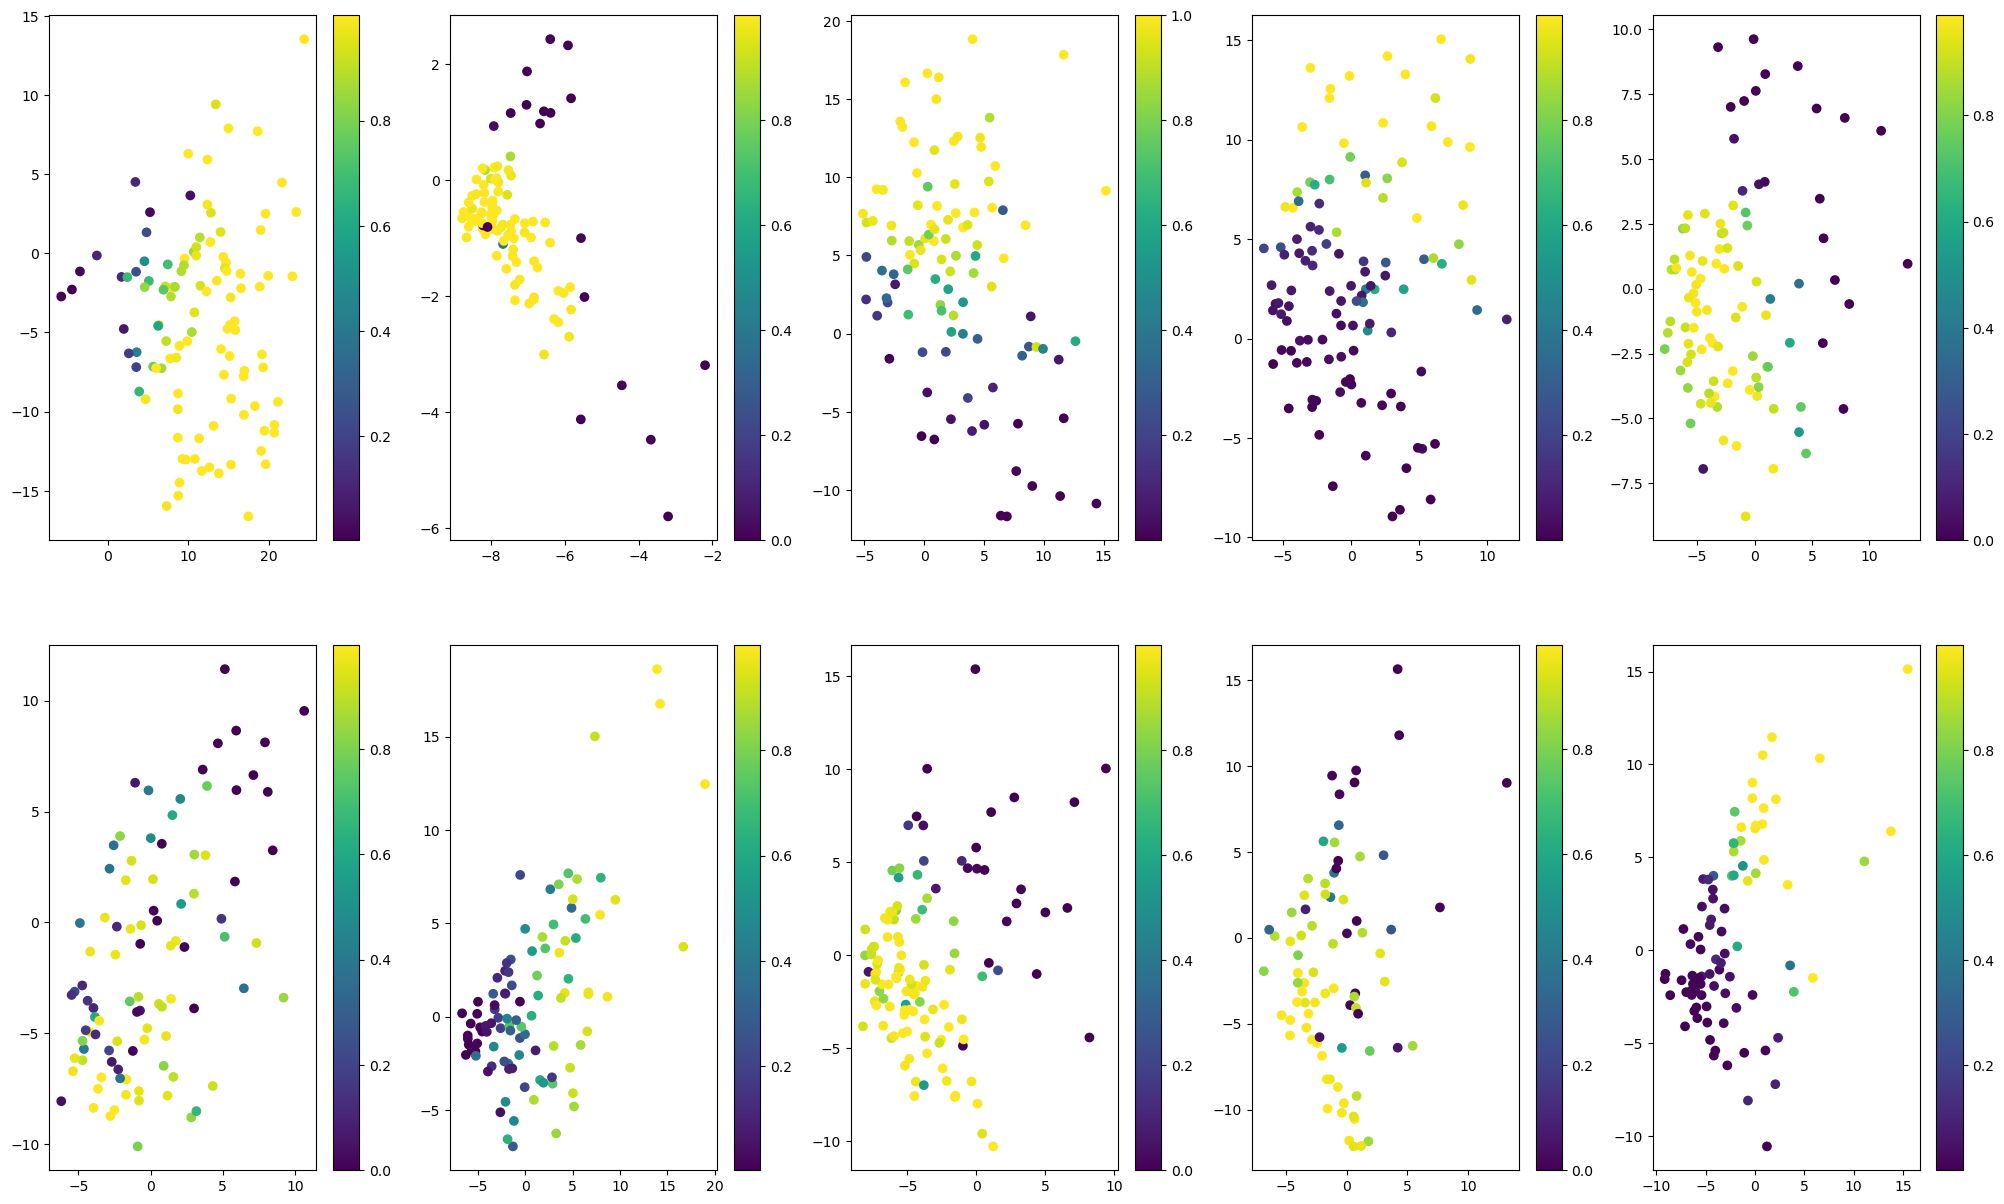

In [42]:
plt.figure(figsize = (25,15))

for ind, lab in enumerate(label_map_5):
    # get the weights from the best cluster for the data points which correspond to digit ind
    plt.subplot(2, 5, ind+1)
    weights = cluster_probabilities(gmm_5, X_GMM_pca)[labels==ind, lab]
    plt.scatter(X_GMM_pca[labels==ind, 0], X_GMM_pca[labels==ind, 1], c=weights)
    plt.colorbar()

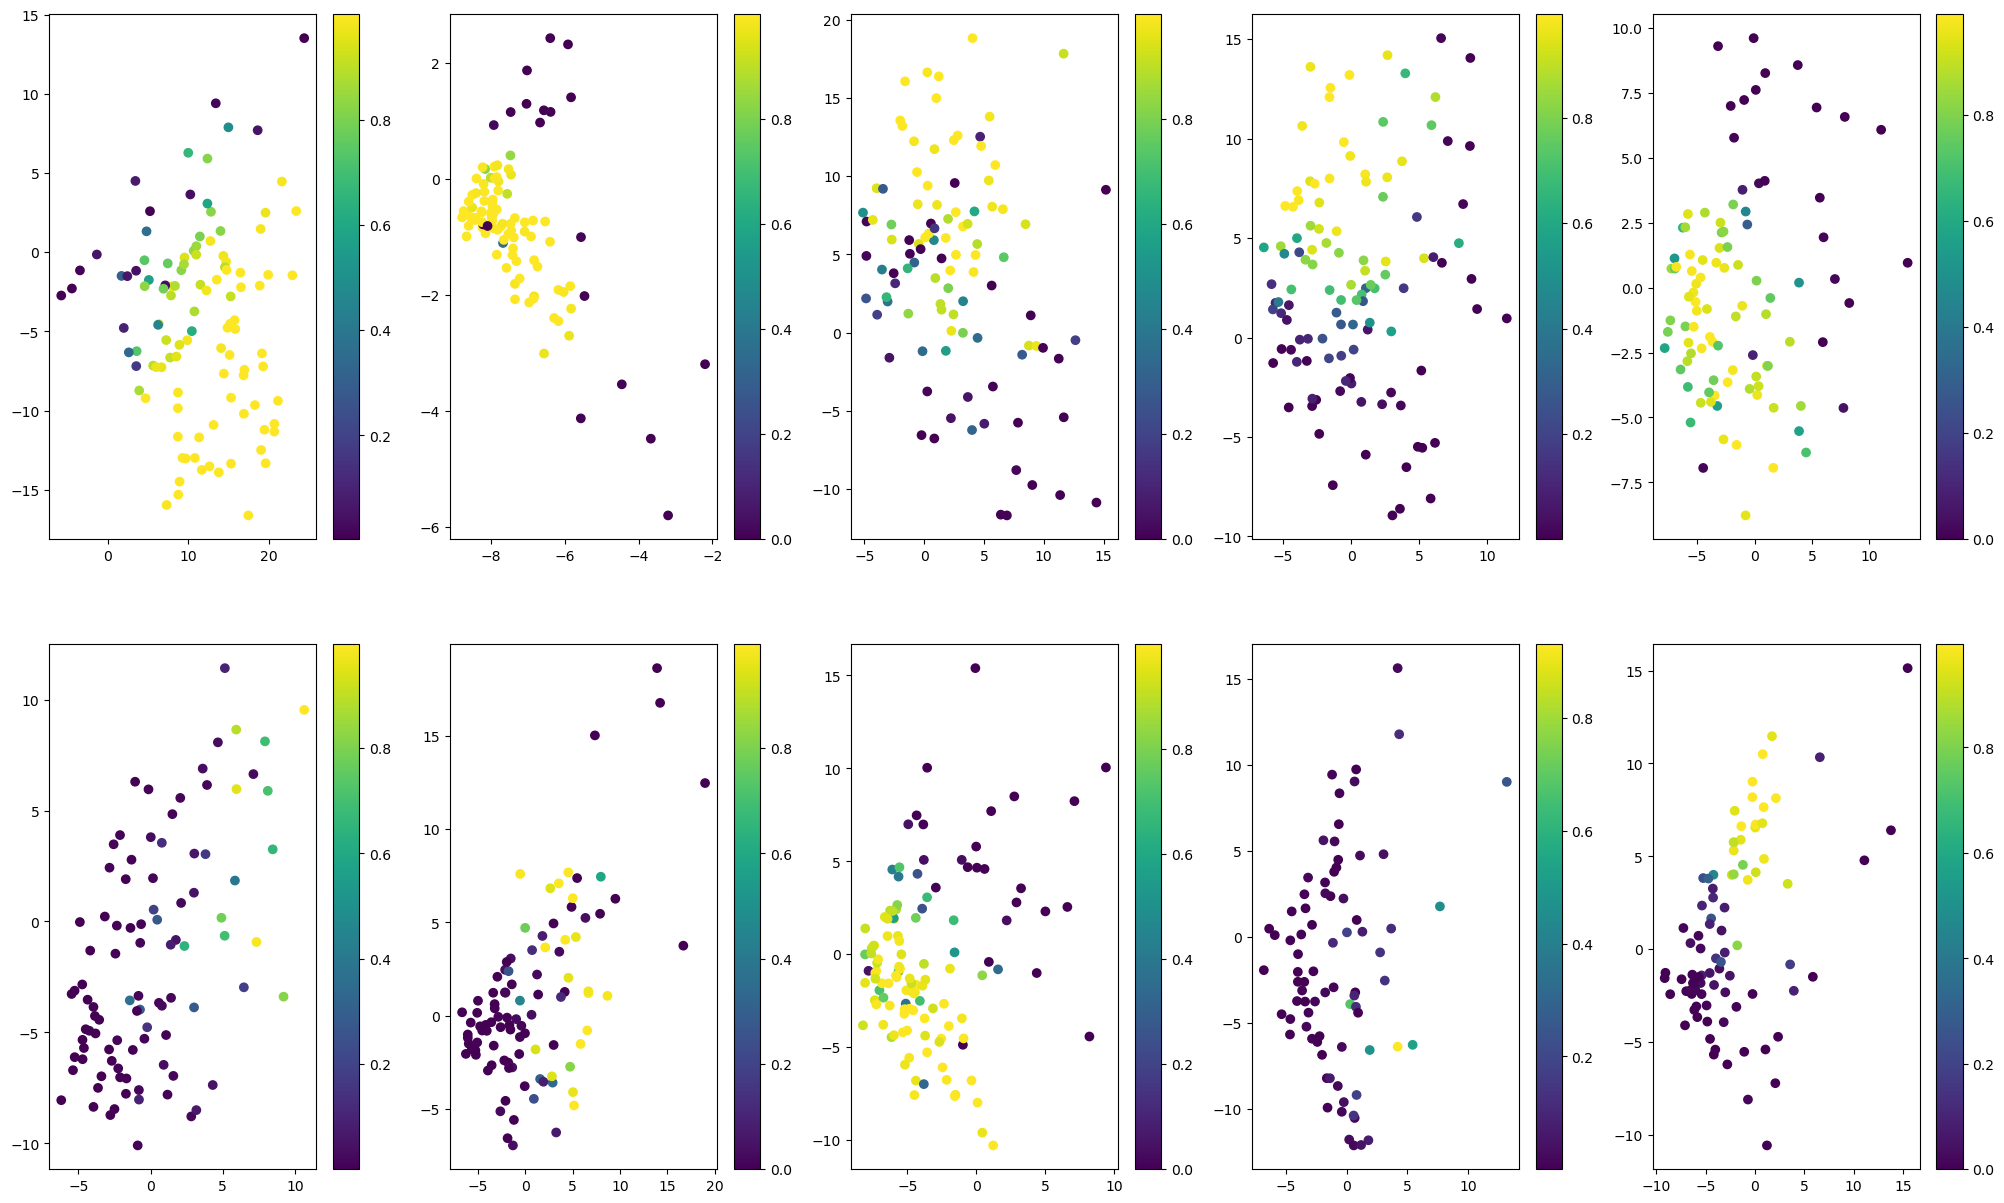

In [43]:
plt.figure(figsize = (25,15))

for ind, lab in enumerate(label_map_8):
    # get the weights from the best cluster for the data points which correspond to digit ind
    plt.subplot(2, 5, ind+1)
    weights = cluster_probabilities(gmm_8, X_GMM_pca)[labels==ind, lab]
    plt.scatter(X_GMM_pca[labels==ind, 0], X_GMM_pca[labels==ind, 1], c=weights)
    plt.colorbar()

There are fewer purple dots in the case we use 5 mixture components compared to the cases when we had 8 and 10 mixture components. This shows that there is more certainty in the classification which means that this model might potentially perform better with unseen data, than the others.

### Task 2: Clustering and graph-based analysis (35 marks)

#### 2.1 Clustering (15 marks)
2.1.1

I have standardised the data below because we will be working with euclidian distance in this k-mean algorithm. 

In [44]:
# read in data
train_k = pd.read_csv("./gene_expression_data.csv")
X_train_k = train_k.iloc[:, :95].to_numpy()
y_train_k = train_k.loc[:, "Type"]

def standardise(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return (X - mu) / sigma

X_train_k = standardise(X_train_k)

In [45]:
# define a function which implements k-means
def k_means(X, k, max_iter=15, print_out=True):
    
    # return the centroid array and the centroid of the whole data
    # return the number of points in each cluster and the labels of each data point
    
    n_samples, n_features = X.shape

    # labels: assign every sample to a cluster at random
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x[0: n_features] for x in X_labels if x[-1]==i], axis=0)
    
    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        if print_out:
            print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            if print_out:
                print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            if print_out:
                print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    
    return centroids, labels

In [46]:
def euclidian_distance(x, y):
    # x and y are arrays
    return np.sqrt(np.sum((x - y) ** 2))

# define a function which calculates the CH for each k:

def CH_score(X, k, max_iter=15):
    
    n_samples, n_features = X.shape
    centroids, labels = k_means(X, k, max_iter, print_out=False)
    
    #between cluster score
    BC = 0
    for i in range(k):
        BC += np.sum(euclidian_distance(centroids[i], np.mean(X, axis=0)) ** 2) * np.sum(labels == i)
    
    # within cluster score
    WC = 0
    for j in range(k):
        WC += np.sum(euclidian_distance(X[labels == j], centroids[j]) ** 2)
    
    # calculate CH using formula
    CH = (BC * (n_samples - k)) / ((k - 1) * WC)
    return CH

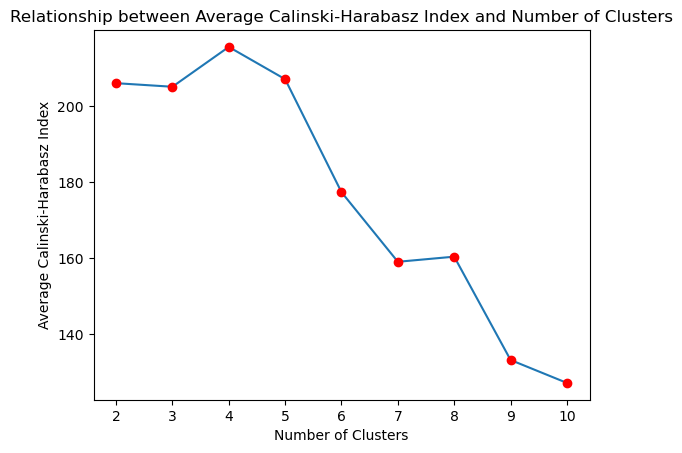

In [47]:
# I have set a seed just for the reproducibility of the plot.

np.random.seed(10)
k_range = np.arange(1, 11, 1)

av_CH_list = []
for k in k_range:
    CH_list = []
    for _ in range(5):
    # running the k_means algorithm 5 times will give five different initialisations because it is random !
        CH = CH_score(X_train_k, k)
        CH_list.append(CH)
    av_CH = np.mean(CH_list)
    av_CH_list.append(av_CH)

plt.plot(k_range, av_CH_list, marker="o", markerfacecolor="red", markeredgecolor="red")
plt.title("Relationship between Average Calinski-Harabasz Index and Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Calinski-Harabasz Index")
plt.show()

In [48]:
_, labels_optimal = k_means(X_train_k, 4, print_out=False)
unique_clusters_k, cluster_size_k = np.unique(labels_optimal, return_counts=True)
print("We have the following clusters {} with respective sizes {}".format(unique_clusters_k, cluster_size_k))

We have the following clusters [0 1 2 3] with respective sizes [327 139 141 193]


2.1.2

In [49]:
def homogeneity_score(y_true, y_pred):
    
    # calculate the homogenity score between y_true which contains the types and y_pred which are the labels
    # convert y_true to numeric labels
    
    # create sets so that we have unique values, same as np.unique
    n_samples = len(y_true)
    clusters = set(y_pred)
    classes = set(y_true)
    # calculate H_C
    H_C = 0
    for c in classes:
        a_c = 0
        for k in clusters:
            a_c += sum((y_true == c) & (y_pred == k))
        H_C -= a_c / n_samples * np.log(a_c / n_samples)
    
    # calculate conditional entropy of clusters given classes
    H_CK = 0
    for k in clusters:
        expr = 0

        # calculate the total sum
        a_k = 0
        for c in classes:
            a_k += sum((y_true == c) & (y_pred == k))
        
        for c in classes:
            a_ck = sum((y_true == c) & (y_pred == k))
            if a_ck > 0:
                expr += a_ck / n_samples * np.log(a_ck / a_k)
        H_CK -= expr
    
    # calculate homogeneity score
    if H_C == 0:
        homogeneity = 1.0
    else:
        homogeneity = 1 - H_CK / H_C
    
    return homogeneity

# choose k=4 because that is the optimal value from the last part
centroids, labels_k = k_means(X_train_k, 4, print_out=False)
print("The homogeneity score is: {}".format(homogeneity_score(y_train_k, labels_k)))

The homogeneity score is: 0.5867971369720714


The homogeneity score of 0.587 means that the k-mean algorithm with 4 clusters performs reasonably well. It indicates that more than half of the data points in a cluster belong to the same class. However, there is still room for improvement, which is why I believe that the clusters are consistent with the tumour types only to some extent. Since the algorithm performs surprisingly good with 4 clusters when there are 5 tumour types, might indicate that a pair of tumour types might be correlated in some way.

#### 2.2 Graph-based analysis (20 marks)
2.2.1

(95, 95)

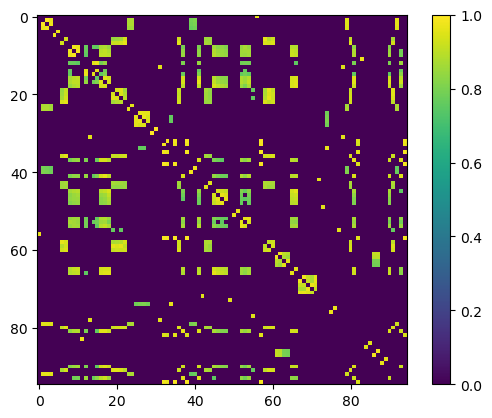

In [50]:
# get data
train_graph = train_k
X_train_graph = train_k.iloc[:, :95].to_numpy()
y_train_graph = y_train_k

# compute correlation matrix
corr_mat = np.corrcoef(X_train_graph, rowvar=False)

# set diagonal terms to zero
np.fill_diagonal(corr_mat, 0)

# and the terms where the absolute value is less than 0.75
corr_mat[abs(corr_mat) < 0.75] = 0

A = corr_mat
plt.imshow(A)
plt.colorbar()
train_graph
A.shape

2.2.2

In [51]:
# compute degree centrality
weighted_degree = A.sum(axis=1)

deg_centrality = weighted_degree / (2 * A.shape[0])

# reverse the sorted indices
ind = np.argsort(deg_centrality, kind="mergesort")[::-1]
print(ind[0:5])

[17 41 16 81 90]


2.2.3

There are 18 zero eigenvalues.


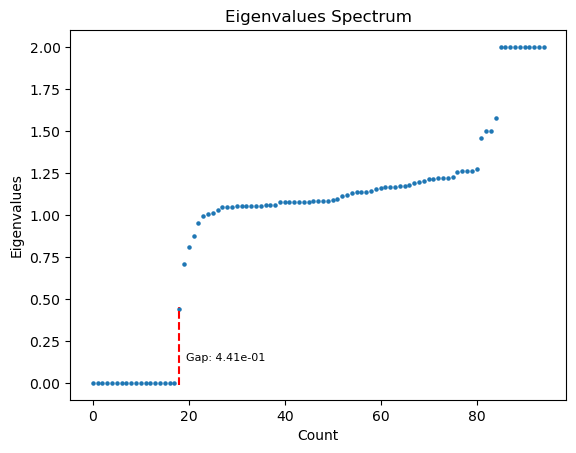

In [52]:
# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

# get eigenvals and eigenvecs
eigenvals, eigenvecs = np.linalg.eig(L_norm)
eigenvals, eigenvecs = np.real(eigenvals), np.real(eigenvecs)

# indexes where eigenvalues are practically zero
ind_zeros = np.where(np.isclose(eigenvals, 0))[0]
r = len(ind_zeros)

if r > 0:
    gap = np.sort(eigenvals)[r]
    plt.axvline(x=r, ymin=0.04, ymax=0.25, color='r', linestyle='--')
    plt.text(r+1.5, 0.3*np.sort(eigenvals)[r], 'Gap: {:.2e}'.format(gap), fontsize=8)

ind_range = np.arange(0, 95)
plt.scatter(ind_range, np.sort(eigenvals), s=5)
plt.xlabel('Count')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues Spectrum')

print(f"There are {r} zero eigenvalues.")

There are 18 zero eigenvalues, which implies that the graph is disconnected. In fact it suggests that there are 18 connected components which make up the graph.

2.2.4

In [53]:
U = eigenvecs[:, ind_zeros]
norms = np.linalg.norm(U, axis=1)
T = U / norms[:, np.newaxis]

# define a function which implements k-means
def k_means_WC(X, k, max_iter=25, print_out=True):
    
    # return the centroid array and the centroid of the whole data
    # return the number of points in each cluster and the labels of each data point
    
    n_samples, n_features = X.shape

    # labels: assign every sample to a cluster at random
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x[0: n_features] for x in X_labels if x[-1]==i], axis=0)
    
    new_labels = np.zeros(len(X))
    difference = 0
    
    # compute distance matrix
    D_matrix = np.zeros((n_samples, n_samples))
    for j in range(n_samples):
        D_matrix[j] = np.linalg.norm(X[j] - X, axis=1)

    # k-means algorithm
    for i in range(max_iter):
        if print_out:
            print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            if print_out:
                print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            if print_out:
                print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    
    # compute distance and assignment matrices
    D = np.zeros((n_samples, n_samples))
    
    # add small value to ensure invertibility
    H = np.zeros((n_samples, k))
    
    for j in range(n_samples):
        D[j] = np.linalg.norm(X[j] - X, axis=1)
        H[j, labels[j]] = 1
    
    nonempty_clusters = np.nonzero(np.sum(H, axis=0))[0]
    H = H[:, nonempty_clusters]
    
    HtHinv = np.linalg.inv(H.T @ H)
    HtDH = H.T @ D @ H
    
    WC = 1/2 * np.trace(HtHinv @ HtDH)
    
    return WC

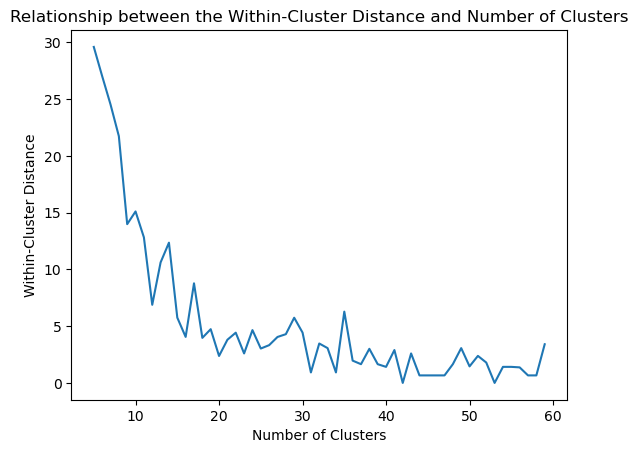

In [54]:
k_range = np.arange(5, 60)
WC_score = []

for k in k_range:
    WC = k_means_WC(T, k, print_out=False)
    WC_score.append(WC)

plt.plot(k_range, WC_score)
plt.title("Relationship between the Within-Cluster Distance and Number of Clusters")
plt.ylabel("Within-Cluster Distance")
plt.xlabel("Number of Clusters")
plt.show()

Using the plot above, we can see that the elbow is in the range 15-20 and so I choose k=18 as this matches the number of zero eigenvalues.

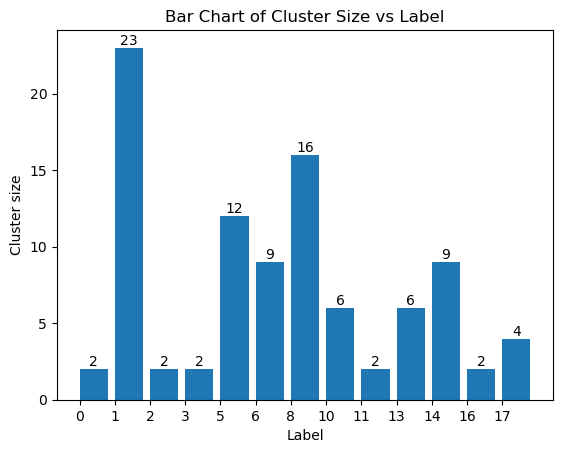

In [55]:
centroids_graph, labels_graph = k_means(T, 18, print_out=False)
unique_labels, label_counts = np.unique(labels_graph, return_counts=True)
default_x_ticks = range(len(unique_labels))
bars = plt.bar(default_x_ticks, label_counts, align="edge")
plt.xticks(default_x_ticks, unique_labels)
plt.title("Bar Chart of Cluster Size vs Label")
plt.xlabel("Label")
plt.ylabel("Cluster size")
plt.bar_label(bars)
plt.show()

We have used k-means clustering to classify the zero eigenvectors of the Laplacian, which involves euclidean distance. Doing this, gives the connected components that we mentioned in `2.2.3`. Each cluster contains coordinates which are correlated to one another.

2.2.5

(14, 14)

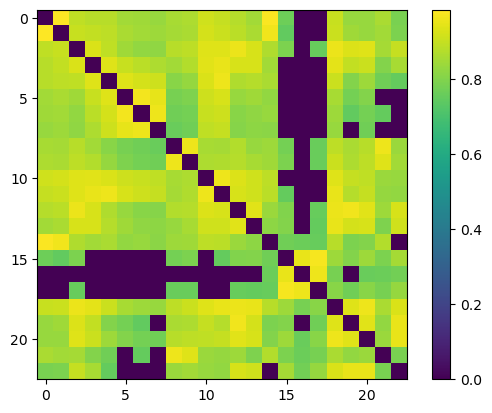

In [56]:
largest_ind = np.argmax(label_counts)
largest_clust = unique_labels[largest_ind] 

# the adjacency of the subgraph
A_subgraph = A[:, labels_graph == largest_clust][labels_graph == largest_clust, :]

sub_weighted_deg = A_subgraph.sum(axis=1)
sub_weighted_deg_sqrt = 1.0 / np.sqrt(sub_weighted_deg)


D_inv_sqrt_sub = np.diag(sub_weighted_deg_sqrt)
# normalised laplacian of the subgraph.
L_norm_sub = np.eye(A_subgraph.shape[0]) - D_inv_sqrt_sub.dot(A_subgraph.dot(D_inv_sqrt_sub))

eig_vals, eig_vecs = np.linalg.eig(L_norm_sub)
eig_vals, eig_vecs = np.real(eig_vals), np.real(eig_vecs)

# get spectral partition
Fiedler_vec = eig_vecs[:, 1]
spectral_partition = Fiedler_vec
spectral_partition[spectral_partition<0] = 0
spectral_partition[spectral_partition>0] = 1

# now we rearrange the adjacency of the subgraph into block diagonal form so that we can visualise the weights
cl2_ind = (spectral_partition == 0)
cl1_ind = (spectral_partition == 1)

# get the within cluster and between cluster weights
A_clust1 = A_subgraph[:, cl1_ind][cl1_ind, :]
A_between12 = A_subgraph[:, cl2_ind][cl1_ind, :]
A_between21 = A_subgraph[:, cl1_ind][cl2_ind, :]
A_clust2 = A_subgraph[:, cl2_ind][cl2_ind, :]

A_block = np.block([[A_clust1, A_between12],
                    [A_between21, A_clust2]])

plt.imshow(A_block)
plt.colorbar()
A_clust1.shape

The heatmap shows that the rearranged block diagonal adjacency matrix. We can see a large patch of zeros in the between-cluster weight blocks (i.e. outside the 14 x 14 and 9 x 9 blocks on the lead diagonal) of the matrix. This indicates that the partitioning performs reasonably well, as it is able to disconnect the data points pretty well. On the other hand, there are yellow patches in the same blocks which show that some data points in different clusters are still connected.

2.2.6

In [57]:
sub_deg_centrality = sub_weighted_deg / (2 * A_subgraph.shape[0])

# reverse the sorted indices
sub_ind = np.argsort(sub_deg_centrality, kind="mergesort")[::-1]

largest_clust_inds = np.where(labels_graph == largest_clust)[0]

transformed_inds = largest_clust_inds[sub_ind]
print(transformed_inds[0:5])

[17 41 16 81 90]


We obtain the same indices as we did in `2.2.2`. This is because the top 5 nodes with the highest degree centrality, are most likely going to be a part of the largest connected component, i.e. the componenet with the highest number of edges.